### Evaluating MMIDAS - Mouse smartseq data
This notebook guides you in analsysing the continuous variables (states) inferred by MMIDAS, focusing on traversal analysis.

In [1]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mmidas.cpl_mixvae import cpl_mixVAE
from mmidas.utils.tools import get_paths
from mmidas.utils.dataloader import load_data, get_loaders
from mmidas.utils.cluster_analysis import K_selection
from mmidas.utils.dataloader import load_data
from mmidas.eval_models import summarize_inference

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


Following steps are similar to categorical evaluation process.

In [2]:
toml_file = 'pyproject.toml'
sub_file = 'smartseq_files'
config = get_paths(toml_file=toml_file, sub_file=sub_file)
data_path = config['paths']['main_dir'] / config['paths']['data_path']
data_file = data_path / config[sub_file]['anndata_file']
data = load_data(datafile=data_file)

/Users/yeganeh.marghi/github/MMIDAS/pyproject.toml
Getting files directories belong to smartseq_files...
data is loaded!
 --------- Data Summary --------- 
num cell types: 115, num cells: 22365, num genes:5032


In [3]:
saving_folder = config['paths']['main_dir'] / config['paths']['saving_path']
trained_model_folder = config[sub_file]['trained_model']
saving_folder = str(saving_folder / trained_model_folder)
trained_models = glob.glob(saving_folder + '/model/cpl_mixVAE_model_*')

##### Construct a cpl-mixVAE object and load the trained model with selected model order at the time categorical evaluation.

In [4]:
n_categories = 120 # upper bound of number of categories (clusters)
state_dim = 2 # continuous (state) variable dimensionality 
n_arm = 2 # number of arms
latent_dim = 10 # latent dimensionality of the model
model_order = 92 # obtained from K_selection
selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
_, _, all_dataloader = get_loaders(dataset=data['log1p'], batch_size=5000, seed=0)

cplMixVAE = cpl_mixVAE(saving_folder=saving_folder)
cplMixVAE.init_model(n_categories=n_categories,
                     state_dim=state_dim,
                     input_dim=data['log1p'].shape[1],
                     lowD_dim=latent_dim,
                     n_arm=n_arm)
outcome = summarize_inference(cplMixVAE, selected_model, all_dataloader)

---> Computional node is not assigned, using CPU!
Model /cpl_mixVAE_model_after_pruning_28_2023-06-22-13-35-00.pth


#### Evaluating continuous variable for a subset of categorical types
Some of the subsequent steps depend on this taxonomy to maintain consistent color coding and annotation with the previous study by [Tasic et al., 2018](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-v1-and-alm-smart-seq).

In [5]:
from statistics import mode

# select an arm, e.g. arm 1
arm = 1 
# load the order of the categorical variable based on taxonomy obtained by MI socres analysis.
c_order = np.load(saving_folder + f'/taxonomy_order_K_{model_order}.npy')

_, data_index = all_dataloader.dataset.tensors
data_index = data_index.numpy().astype(int)
categories = outcome['pred_label'][-1][arm]
c_cat = np.unique(categories)
T_annotation = []
T_color = []
    
for ic, cc in enumerate(c_cat):
    idx_c = np.where(categories == cc)[0]
    title = np.unique(data['cluster'][data_index][idx_c])
    t_type = mode(data['cluster'][data_index][idx_c])

    if t_type[:t_type.find(' ')] in ['L2/3', 'L4', 'L5', 'L6']:
        anno = t_type[:t_type.find(' ') + 3]
    else:
        anno = t_type[:t_type.find(' ')]
    
    T_indx = np.where(c_order == cc - 1)[0][0] + 1
    T_annotation.append(anno + ' T_' + str(T_indx))
    T_color.append(mode(data['cluster_color'][data_index][idx_c]))

T_annotation = np.array(T_annotation)
T_color = np.array(T_color)

##### Choose a subset of categorical variables for conducting traversal analysis on gene expression across pathway-associated gene modules

In [6]:
selected_c = [80, 119, 1, 13, 92, 25, 55, 110, 62, 69, 31]
color, c_ano = [], []

for cc in selected_c:
    i_cc = np.where(c_cat == cc)[0][0]
    color.append(T_color[i_cc])
    c_ano.append(T_annotation[i_cc])
    print(cc, i_cc, c_ano[-1])

color = np.array(color)
c_ano = np.array(c_ano)

80 60 Lamp5 T_45
119 90 Lamp5 T_46
1 0 Lamp5 T_47
13 7 Sst T_73
92 69 Vip T_61
25 17 Vip T_64
55 41 Vip T_65
110 84 L5 NP T_32
62 46 L2/3 IT T_1
69 52 L2/3 IT T_4
31 22 L5 IT T_14


In [7]:
mode = 'pca'
file = open(saving_folder + f'/State/traversal_{mode}_K_{model_order}_2.pickle', 'rb')
sum_dict = pickle.load(file)
g_var_mean = sum_dict['V_g_mean']
g_var_std = sum_dict['V_g_std']
g_subset = sum_dict['g_subset'] 
c_cat = sum_dict['c_cat']
signaling_pathways = sum_dict['pathways'] 


s_idx = outcome['sample_id'][-1].astype(int)
gene_exp = data['log1p'][s_idx, :]
c_label = outcome['pred_label'][-1][0, :]
g_std = np.std(data['log1p'], axis=0)

##### Variation in gene expression Using KEGG pathway database
The subfigures illustrate box plots showcasing the overall variation in gene subsets contributing to various distinct pathways. Additional information about the involved pathways can be accessed on the following GitHub repository: https://github.com/AllenInstitute/MMIDAS/tree/main/KEGG.

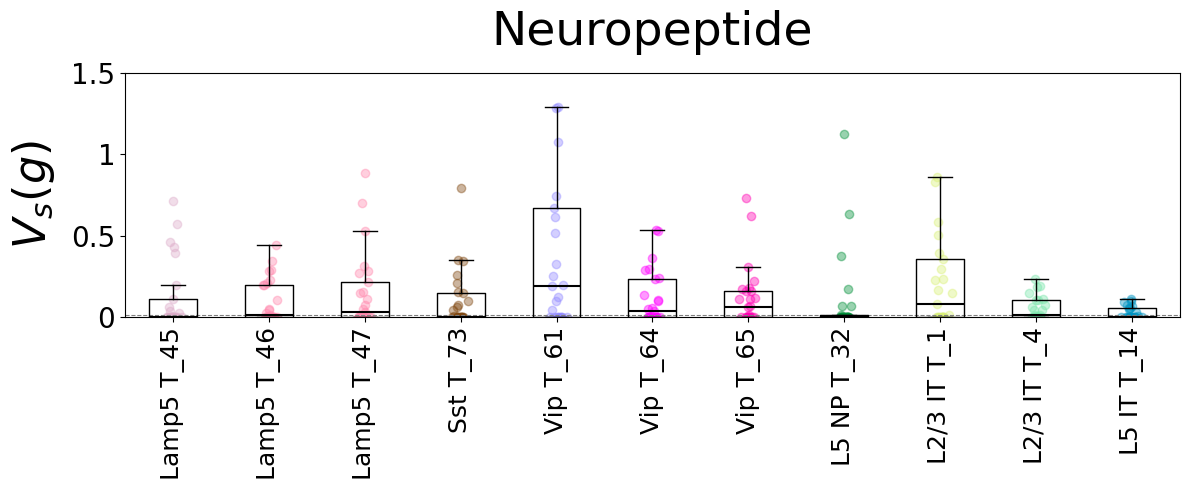

Pathway: Neuropeptide, Overall median of variation of gene modules: 0.01297078188508749


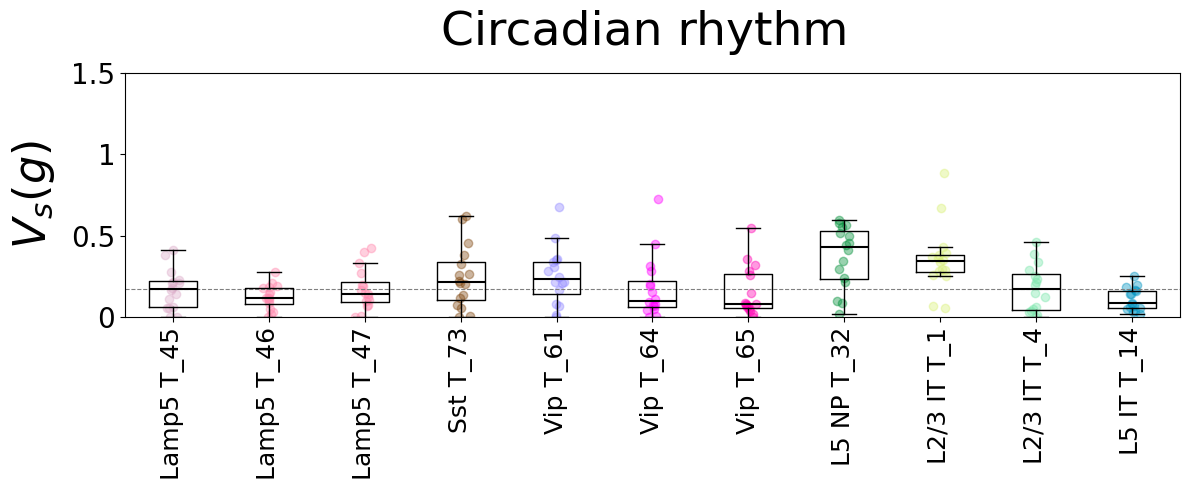

Pathway: Circadian rhythm , Overall median of variation of gene modules: 0.17240682244300842


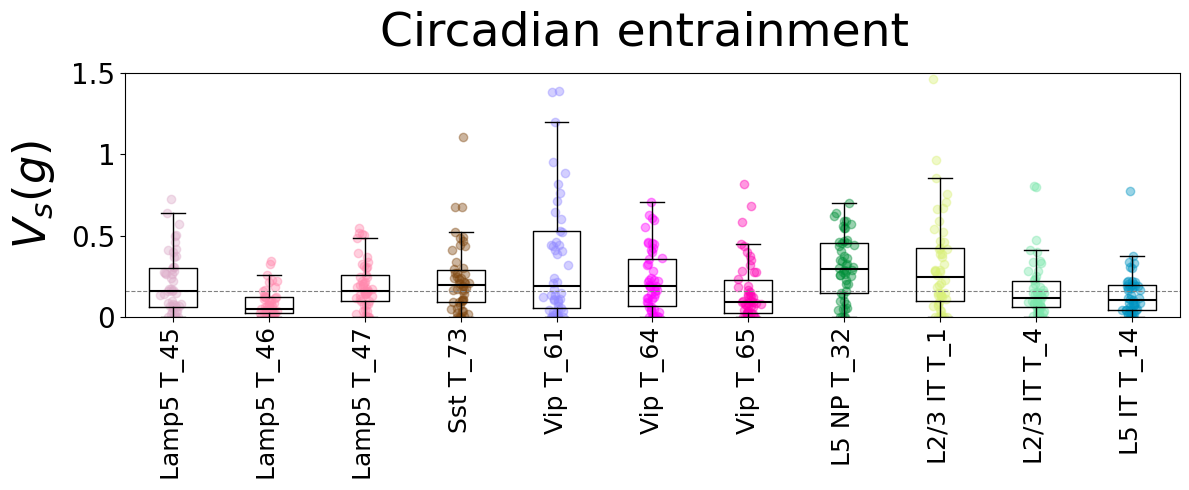

Pathway: Circadian entrainment , Overall median of variation of gene modules: 0.16268085688352585


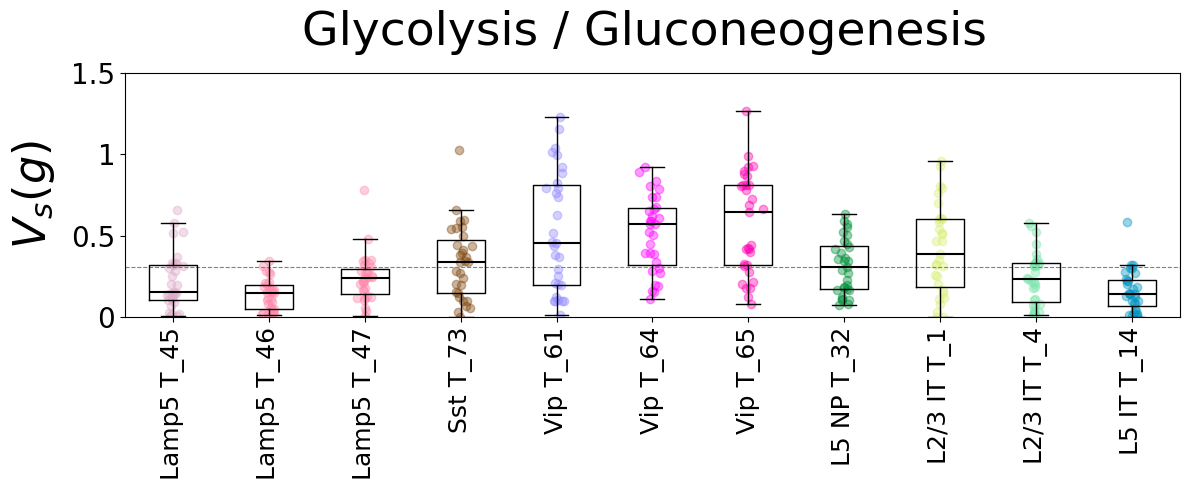

Pathway: Glycolysis / Gluconeogenesis , Overall median of variation of gene modules: 0.31049859523773193


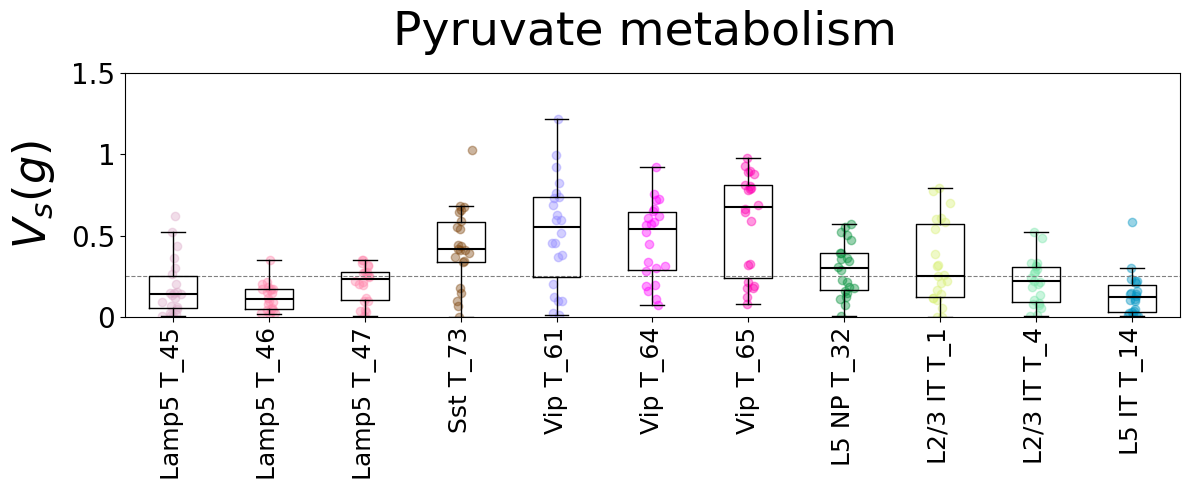

Pathway: Pyruvate metabolism , Overall median of variation of gene modules: 0.25530561804771423


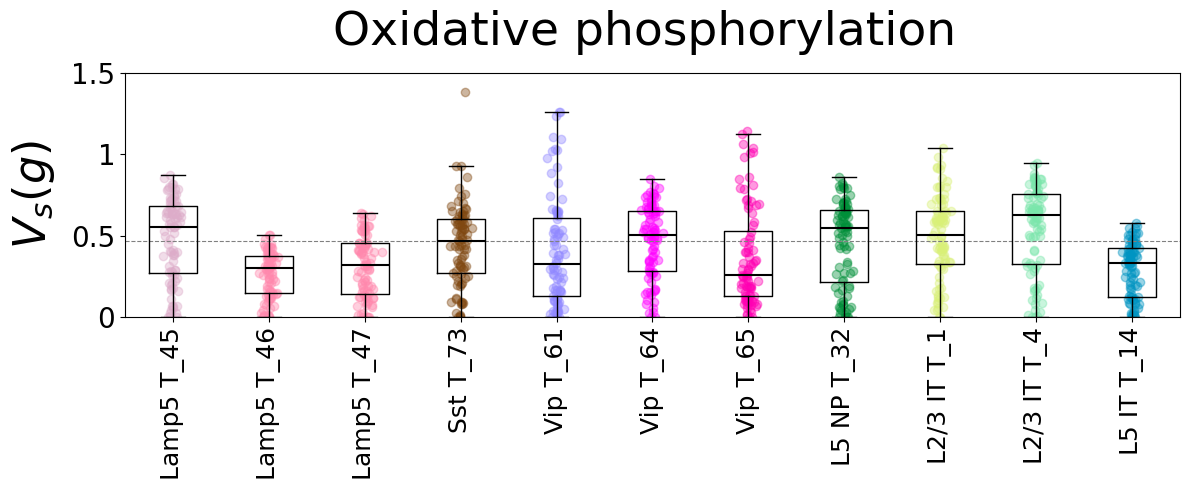

Pathway: Oxidative phosphorylation , Overall median of variation of gene modules: 0.4692787379026413


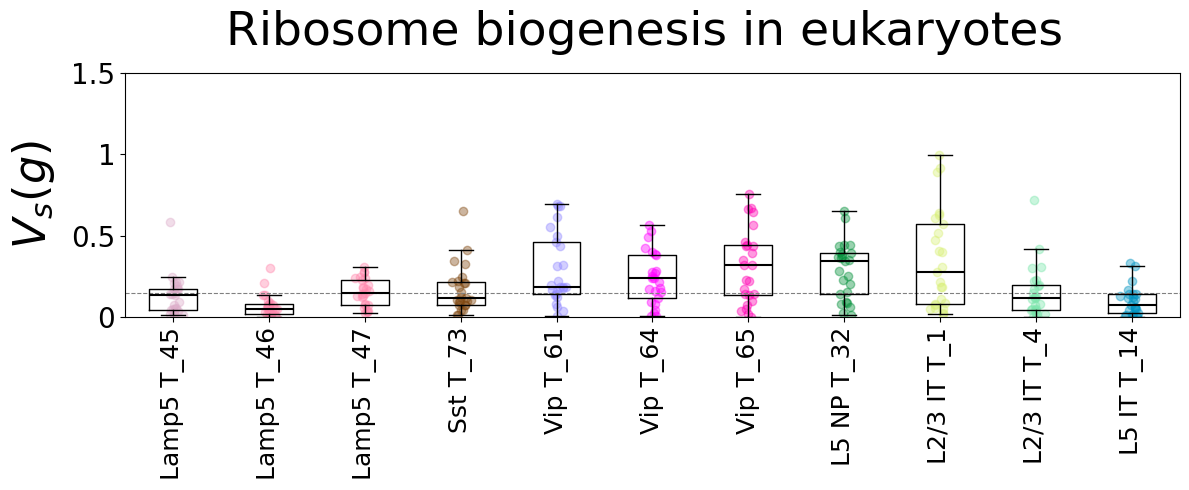

Pathway: Ribosome biogenesis in eukaryotes , Overall median of variation of gene modules: 0.1473878026008606


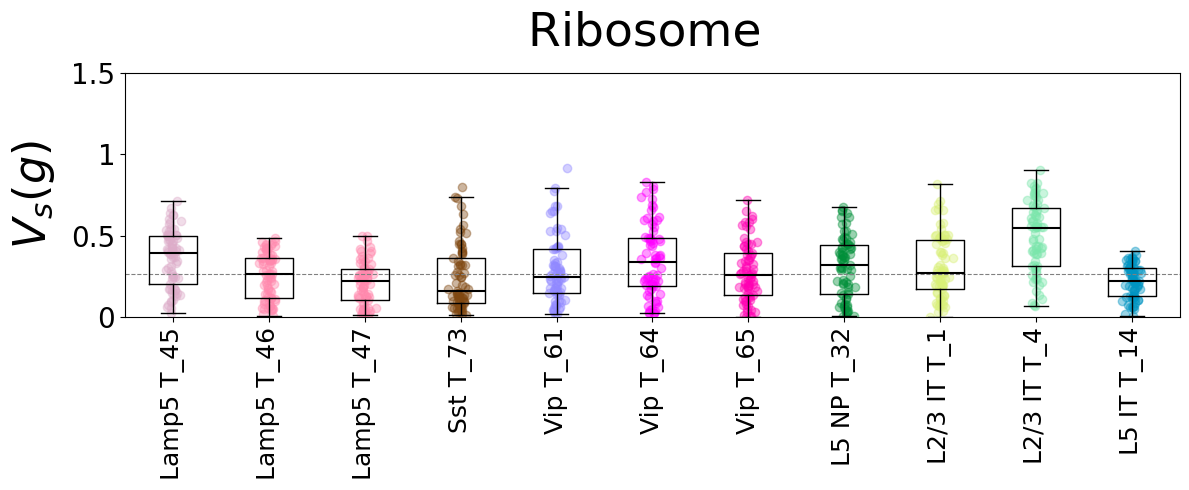

Pathway: Ribosome , Overall median of variation of gene modules: 0.2620195150375366


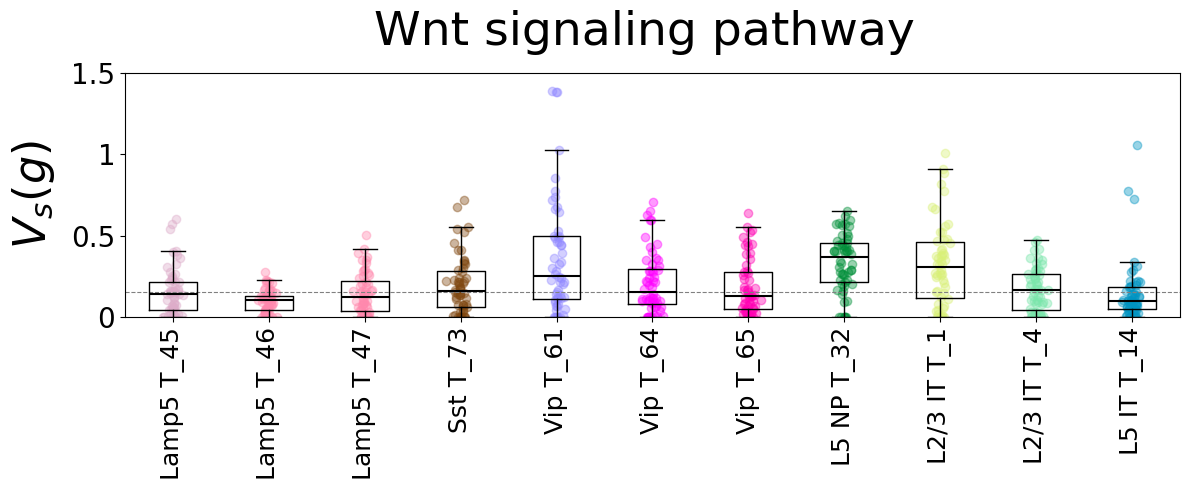

Pathway: Wnt signaling pathway , Overall median of variation of gene modules: 0.15569757670164108


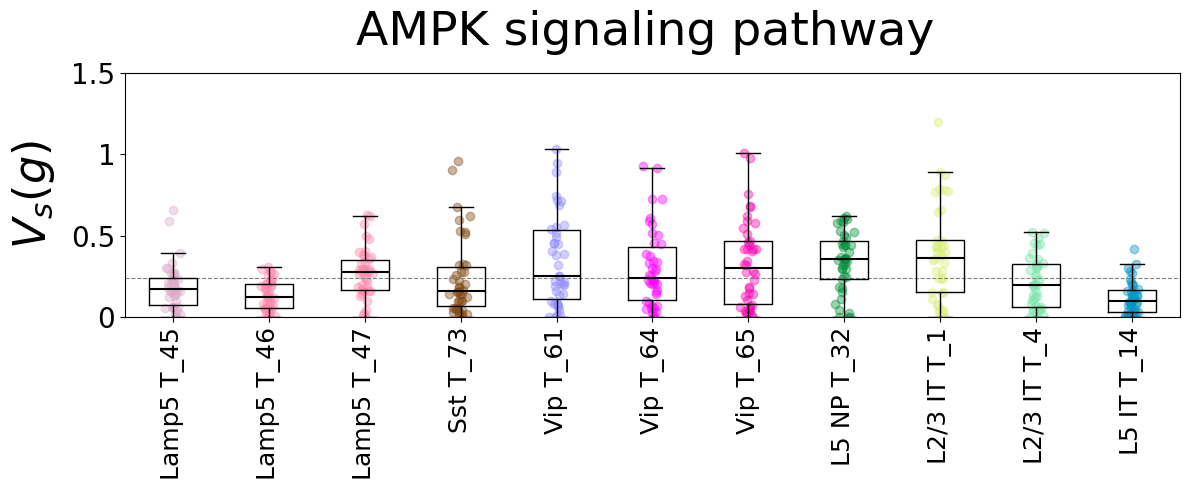

Pathway: AMPK signaling pathway , Overall median of variation of gene modules: 0.24027316272258759


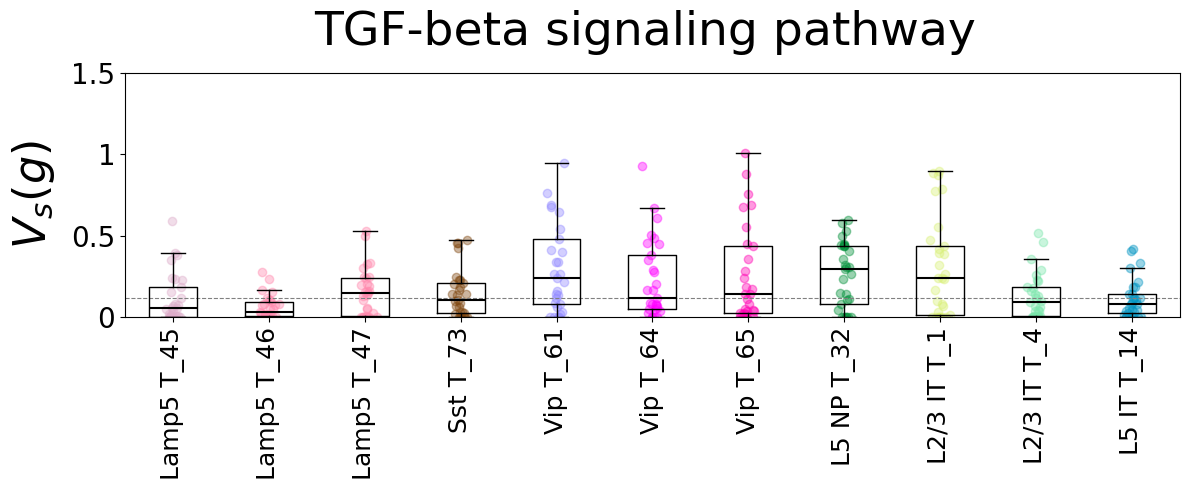

Pathway: TGF-beta signaling pathway , Overall median of variation of gene modules: 0.11944039911031723


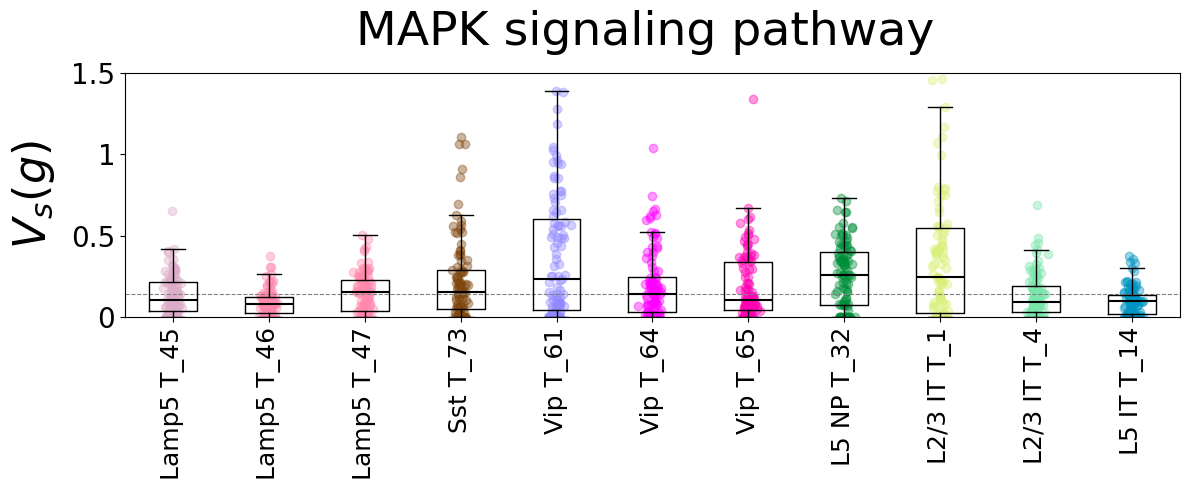

Pathway: MAPK signaling pathway , Overall median of variation of gene modules: 0.1451510787010193


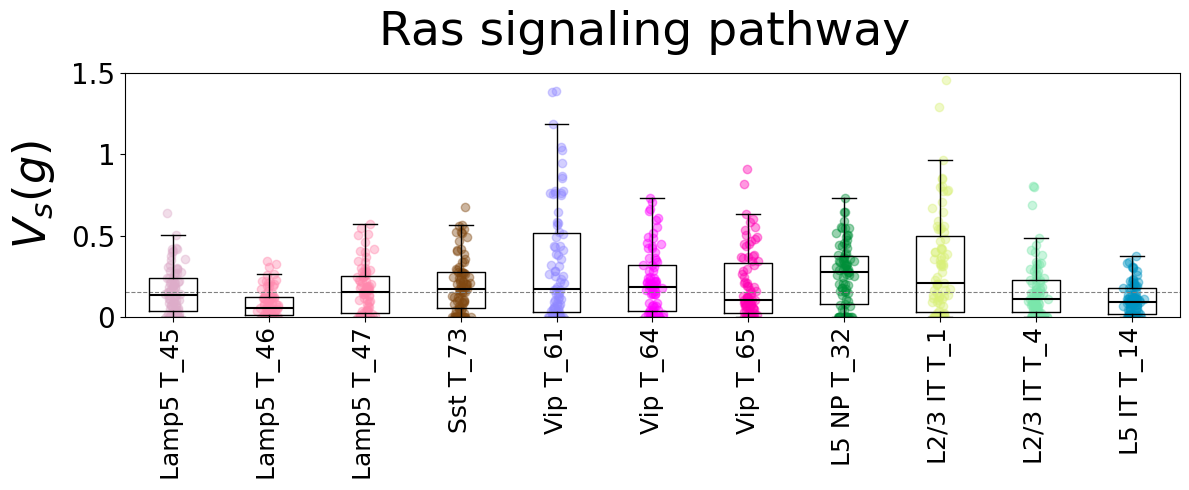

Pathway: Ras signaling pathway , Overall median of variation of gene modules: 0.15571990609169006


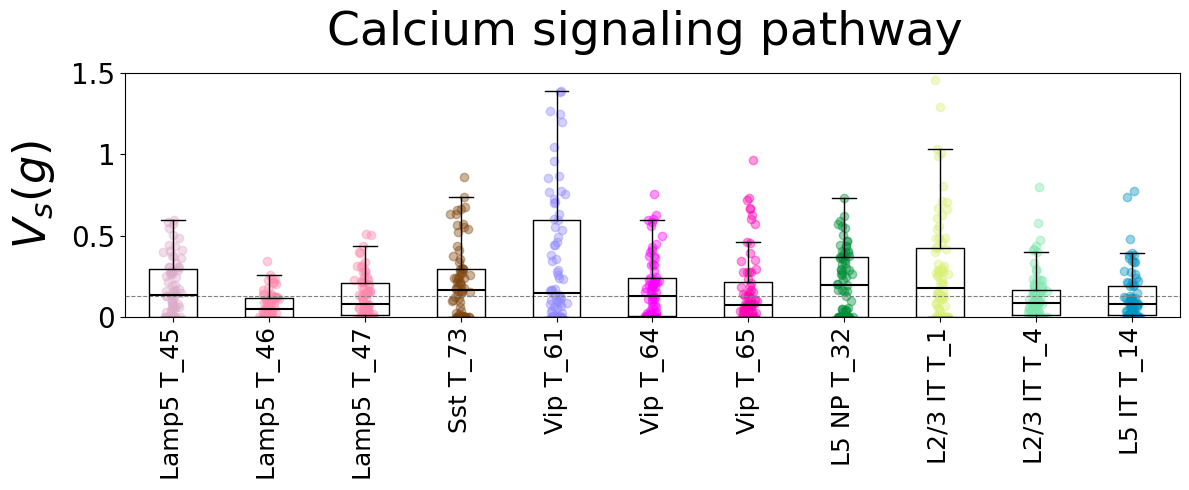

Pathway: Calcium signaling pathway , Overall median of variation of gene modules: 0.1307470127940178


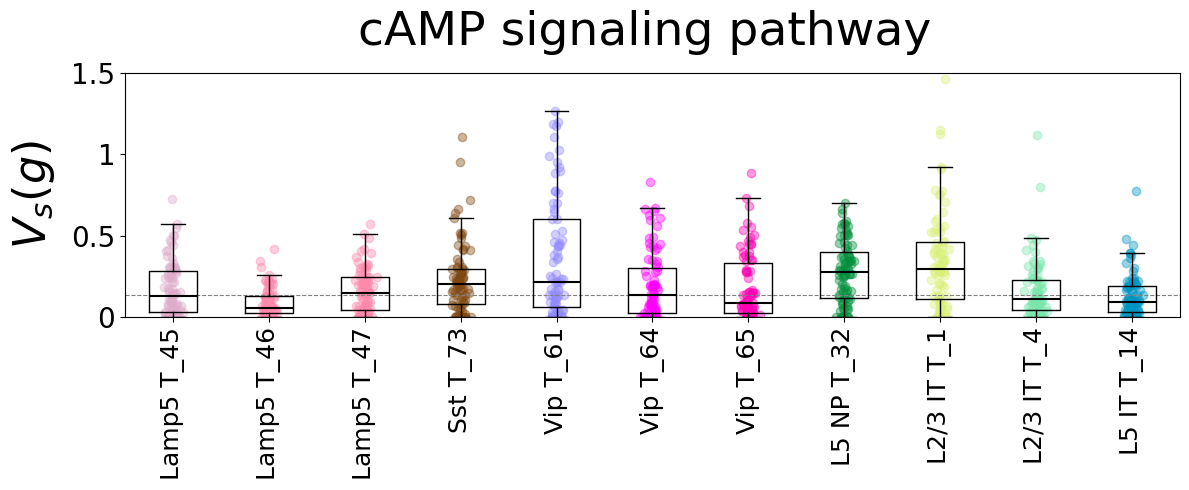

Pathway: cAMP signaling pathway , Overall median of variation of gene modules: 0.1333334967494011


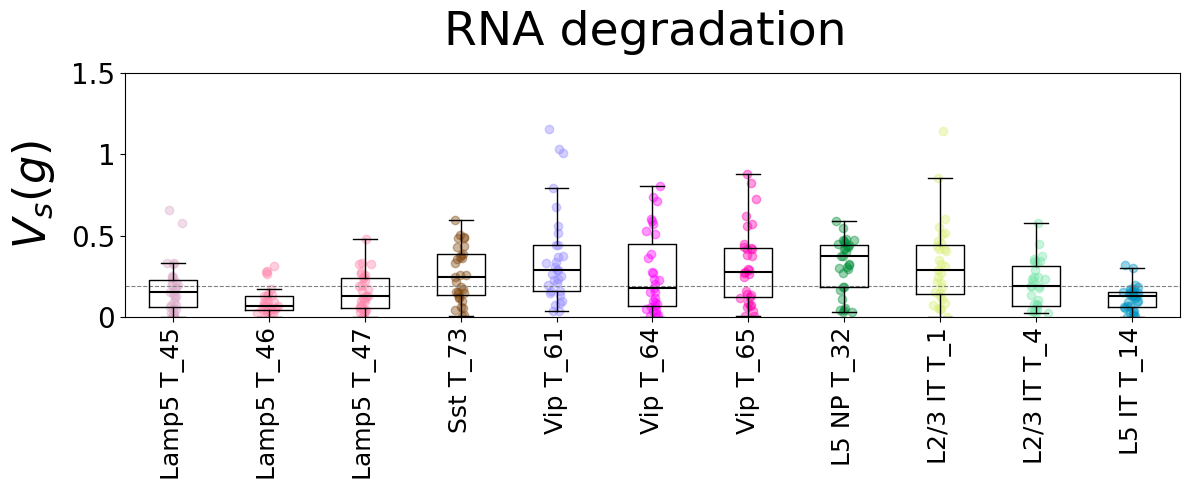

Pathway: RNA degradation , Overall median of variation of gene modules: 0.1887737214565277


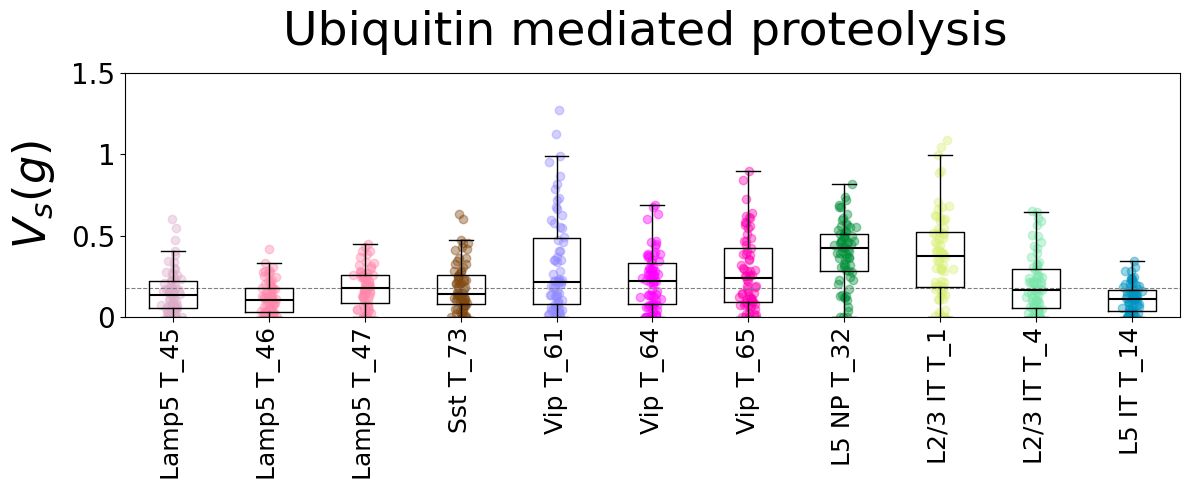

Pathway: Ubiquitin mediated proteolysis , Overall median of variation of gene modules: 0.18187933415174484


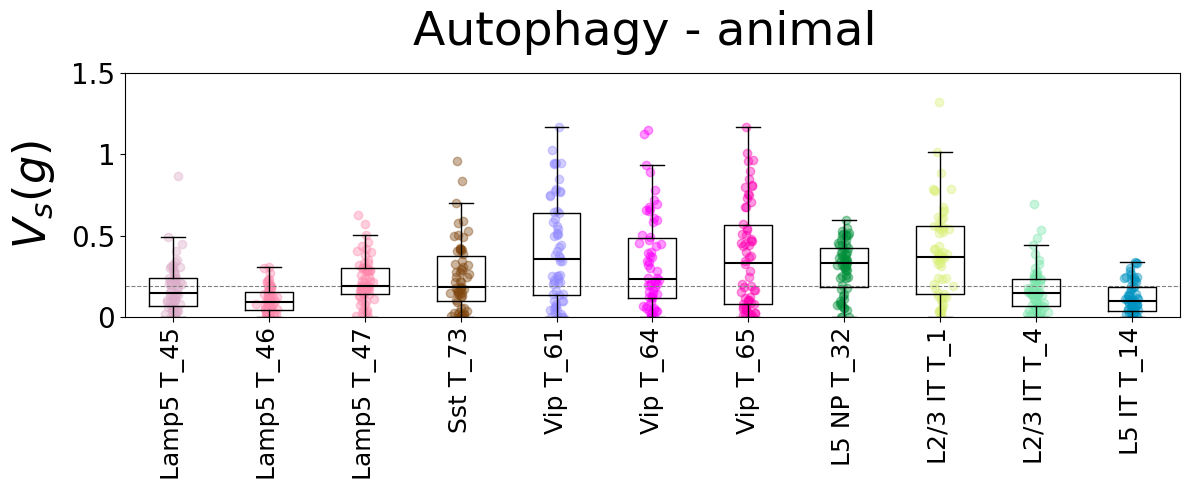

Pathway: Autophagy - animal , Overall median of variation of gene modules: 0.19241593778133392


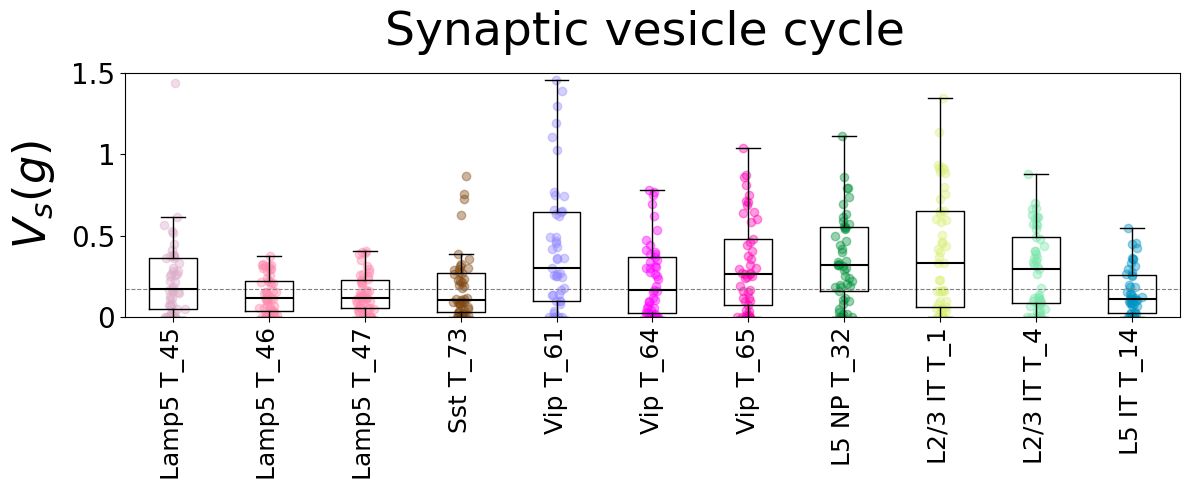

Pathway: Synaptic vesicle cycle , Overall median of variation of gene modules: 0.17460528016090393


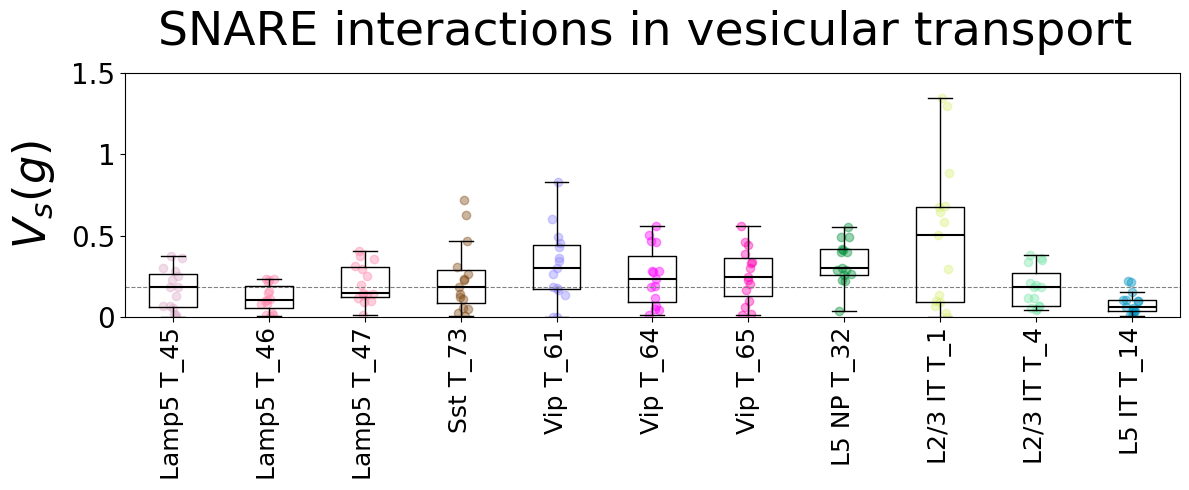

Pathway: SNARE interactions in vesicular transport , Overall median of variation of gene modules: 0.1856456696987152


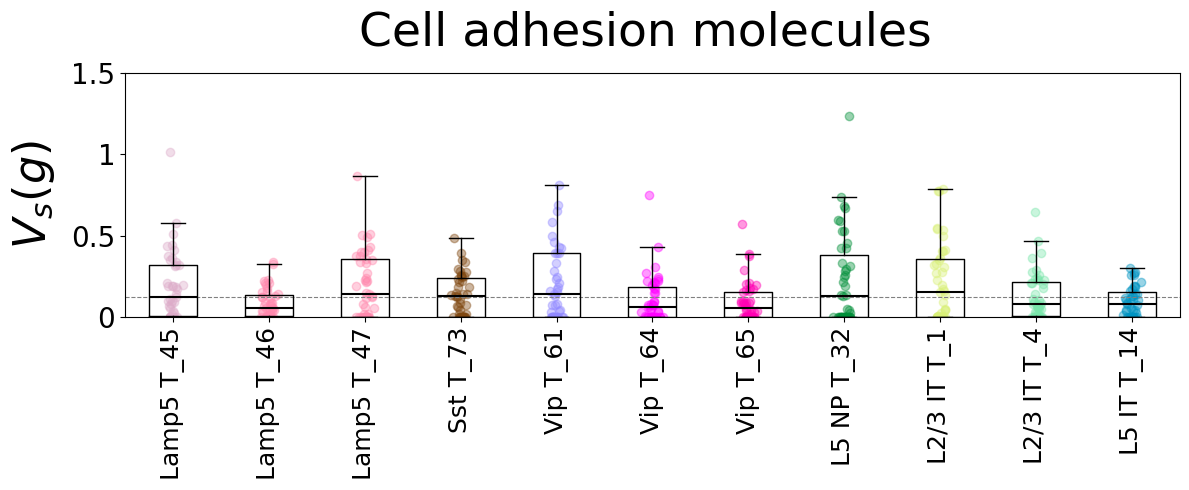

Pathway: Cell adhesion molecules , Overall median of variation of gene modules: 0.12181851267814636


In [8]:
boxprops = dict(color="black", linewidth=1)
medianprops = dict(color="black", linewidth=1.5)

for ig, g_s in enumerate(g_subset):
    if ig == 0:
        g_s = np.concatenate((g_subset[0], g_subset[1]))
        sig_path = 'Neuropeptide'
    elif ig == 1:
        continue
    else:
        g_s = np.array(g_s)
        sig_path = signaling_pathways[ig]
        
    vals, names, xs = [], [], []
    med_value = []
    plt.figure(figsize=[12, 5])
    for i_c, cc in enumerate(selected_c):
        c_idx = np.where(c_cat==cc)[0][0]
        indx = np.where(c_label == cc)[0]
        sum_exp_c = np.sum(gene_exp[indx, :], axis=0)
        nzg_indx = np.where(sum_exp_c[0, g_s] > 0)[0]
        g_travers = g_var_mean[c_idx, 1, 0, g_s]
        med_value.append(np.median(g_travers))
        vals.append(g_travers)
        names.append(c_ano[i_c])
        xs.append(np.random.normal(i_c + 1, 0.04, g_travers.shape[0]))  

    plt.plot(np.linspace(0.5, len(selected_c)+.5, 10), np.median(med_value)*np.ones(10), 
             linestyle='--', linewidth=0.8, color='gray')
    plt.boxplot(vals, labels=names, showfliers=False, boxprops=boxprops, medianprops=medianprops)
    for x, val, c in zip(xs, vals, color):
        plt.scatter(x, val, alpha=0.4, color=c)
    plt.title(sig_path, fontsize=34, pad=20)
    plt.ylabel(r'$V_{s}(g)$', fontsize=32, labelpad=10)
    plt.xticks(fontsize=18, rotation=90)
    plt.ylim([0, 1.5])
    plt.yticks([0, 0.5, 1, 1.5], [0, 0.5, 1, 1.5], fontsize=20)
    plt.tight_layout()
    plt.savefig(saving_folder + f'/State/signaling_pathways/s_pc_path_{ig+1}_K_{model_order}_2.png', dpi=300)
    plt.show()
    print(f'Pathway: {sig_path}, Overall median of variation of gene modules: {np.median(med_value)}')
    
    


NPP
Oxidative phosphorylation 


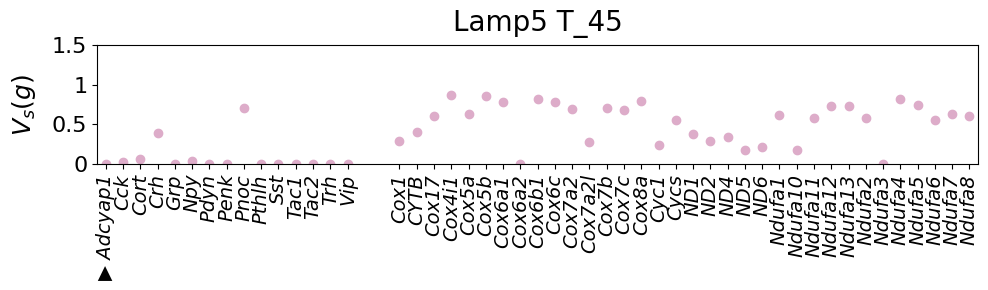

NPP
Oxidative phosphorylation 


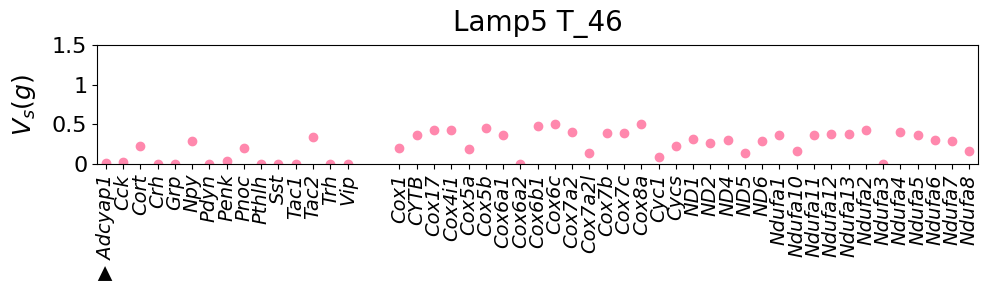

NPP
Oxidative phosphorylation 


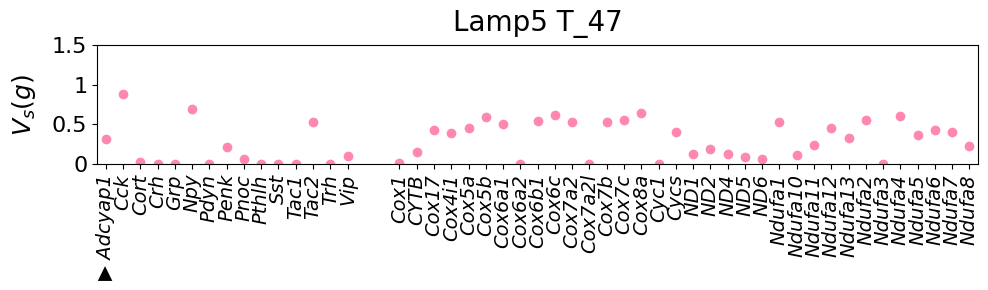

NPP
Oxidative phosphorylation 


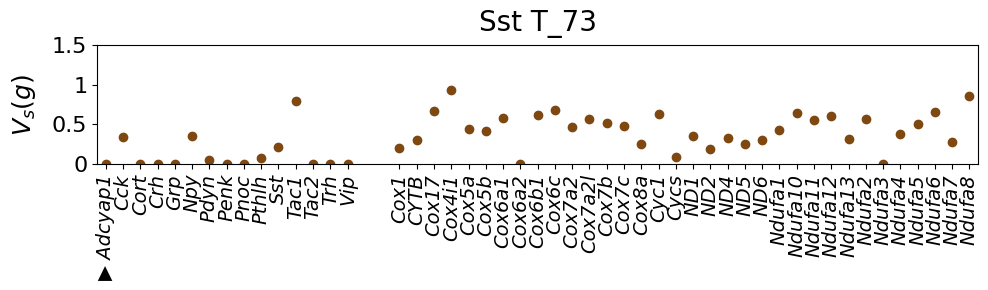

NPP
Oxidative phosphorylation 


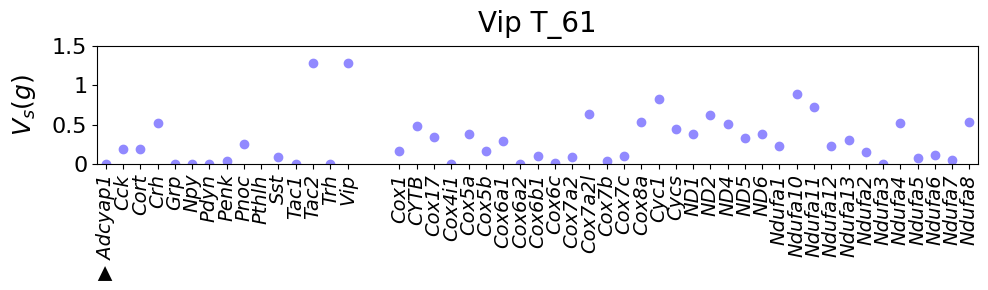

NPP
Oxidative phosphorylation 


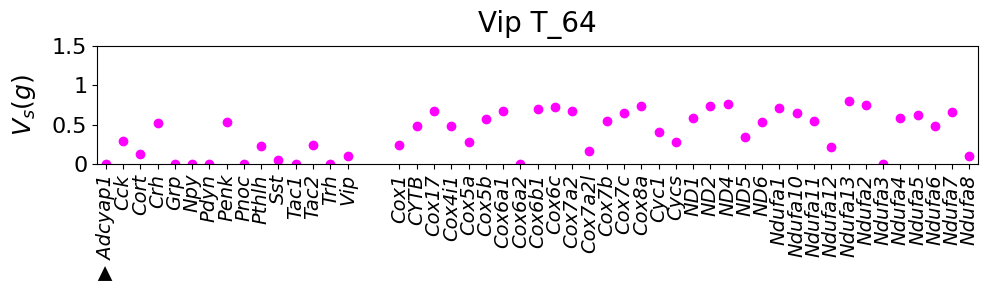

NPP
Oxidative phosphorylation 


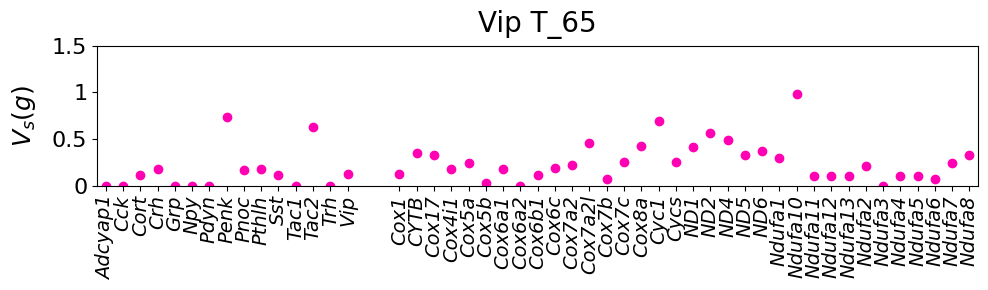

NPP
Oxidative phosphorylation 


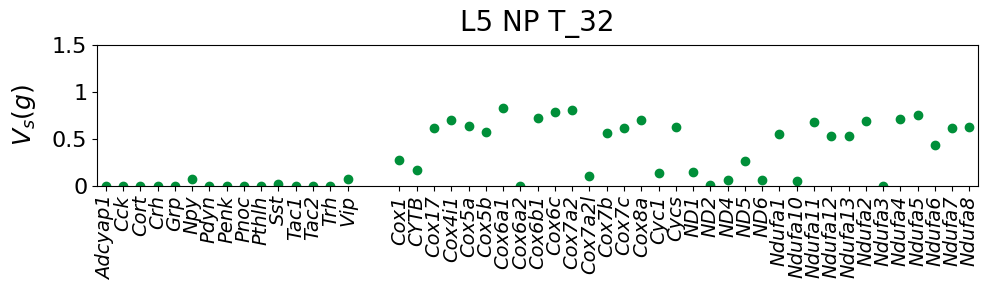

NPP
Oxidative phosphorylation 


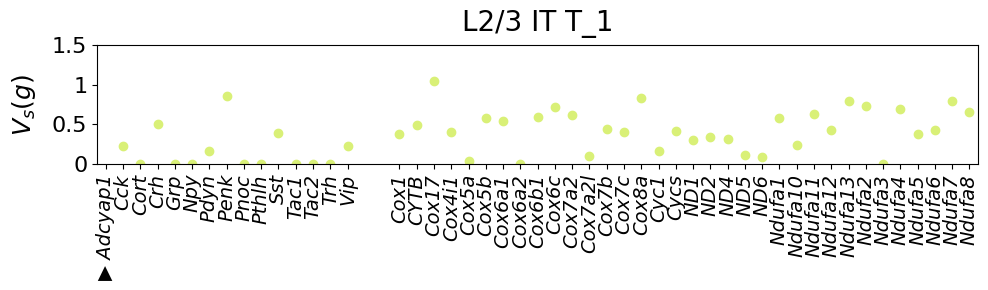

NPP
Oxidative phosphorylation 


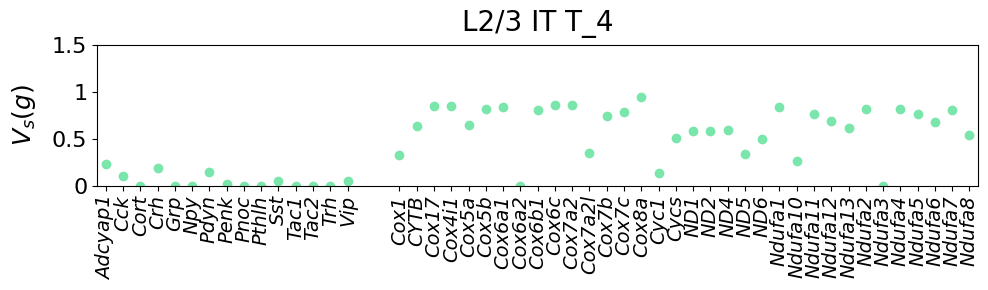

NPP
Oxidative phosphorylation 


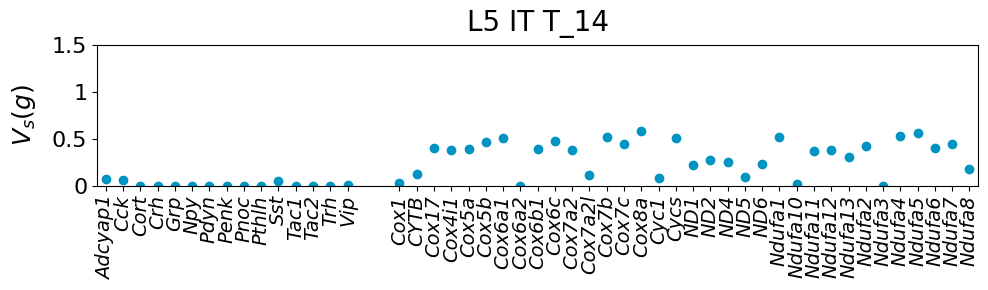

In [9]:
gg_s = []
path_idx = [0, 6]
gg_s.append(g_subset[0])
gg_s.append(g_subset[6][16:50])
shift = 3

for i_cat, cc in enumerate(selected_c): 
    c_idx = np.where(c_cat==cc)[0][0]

    for arm in range(1, 2):
        g_travers = g_var_mean[c_idx, arm, 0, :]
        fig, ax = plt.subplots(figsize=[10, 3])
        xticks = []
        xtick_label = []
        for ig, g_s in enumerate(gg_s):
            print(signaling_pathways[path_idx[ig]])
            if ig > 0:
                x_s = np.arange(len(g_s)) + shift + x_s[-1]
            else:
                x_s = np.arange(len(g_s))

            ax.errorbar(x_s, g_travers[g_s], yerr=0, linestyle='None', fmt='o', 
                        markersize=6, capsize=2, color=color[i_cat])
            xticks.append(x_s)
            g_label = data['gene_id'][g_s]
            if 'COX1' in g_label:
                cox_idx = np.where(g_label == 'COX1')[0][0]
                g_label[cox_idx] = 'Cox1'
                
            indx = np.where(c_label == cc)[0]
            sum_exp_c = np.sum(gene_exp[indx, :], axis=0)
            zg_indx = np.where(sum_exp_c[0, g_s] == 0)[0]
            new_g = ['▶ ' + sg for sg in g_label[zg_indx]]
            g_label[zg_indx] = new_g
            xtick_label.append(g_label)

        xticks = np.concatenate(xticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.concatenate(xtick_label), rotation=90, fontsize=14, style='italic')
        ax.set_xlabel('')
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
            tick.set_fontsize(12)

        ax.set_ylabel(r'$V_{s}(g)$', fontsize=18, labelpad=10)
        ax.set_xlim([xticks[0] - .5, xticks[-1] + .5])
        ax.set_ylim([0, 1.5])
        plt.yticks([0, 0.5, 1, 1.5], [0, 0.5, 1, 1.5], fontsize=16)
        ax.set_title(c_ano[i_cat], fontsize=20, pad=10)
        plt.tight_layout()
        plt.savefig(saving_folder + f'/State/traversal_{cc}_pc_1_arm_{arm}.png', dpi=600)
        plt.show()

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


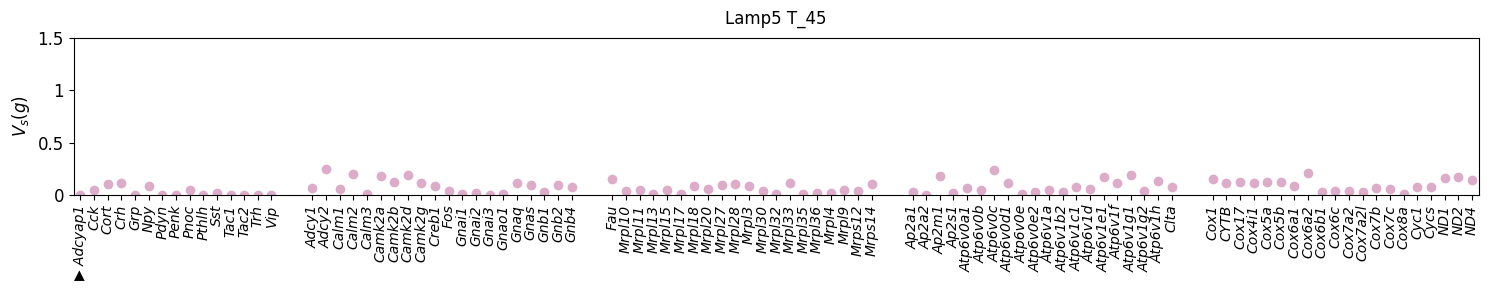

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


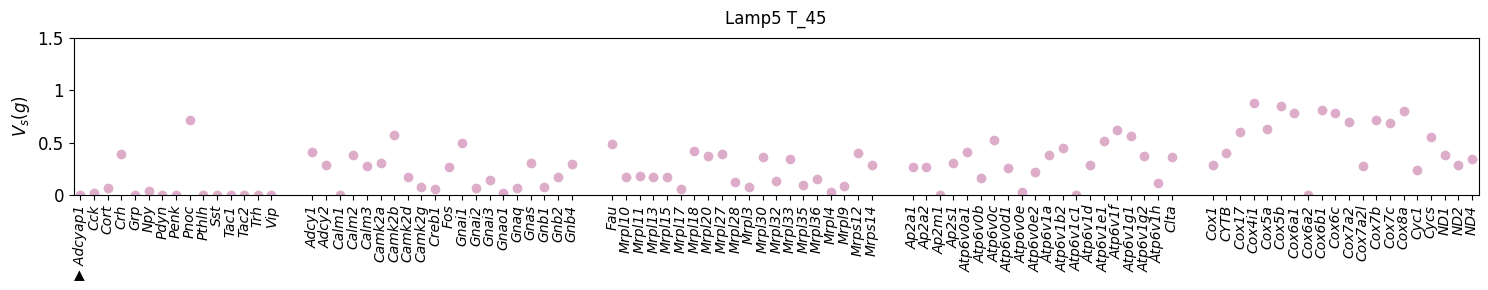

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


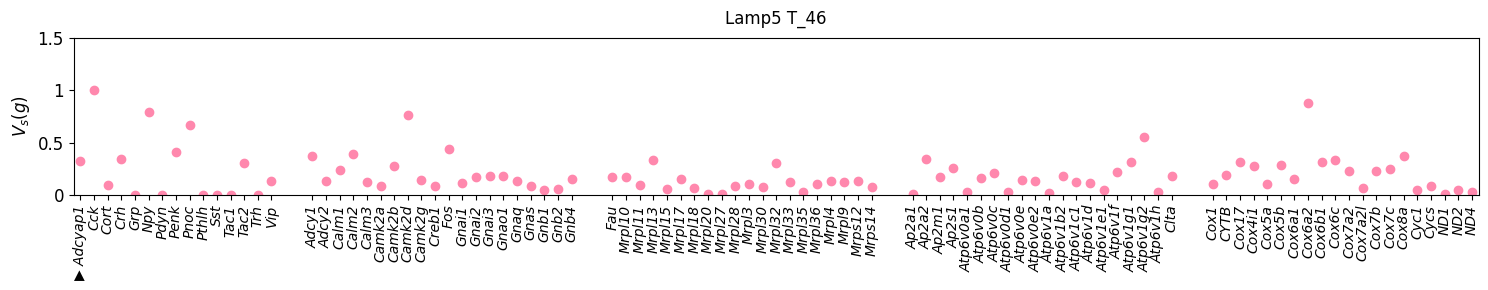

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


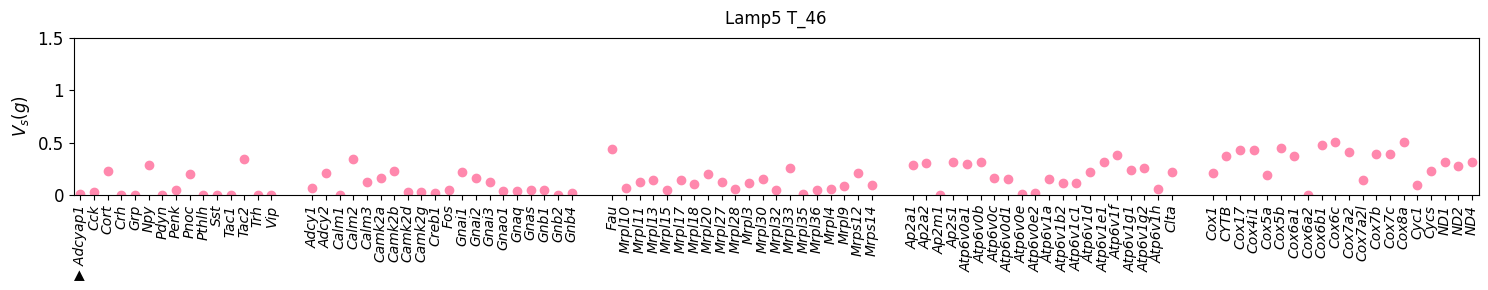

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


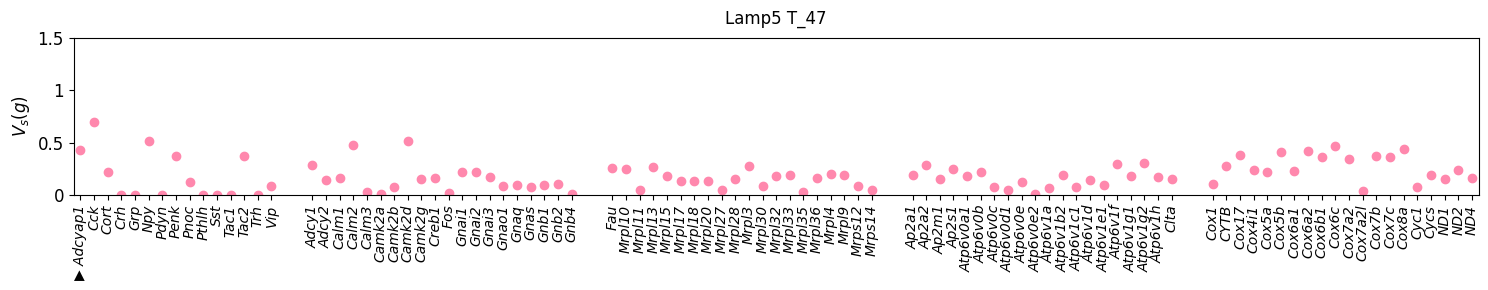

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


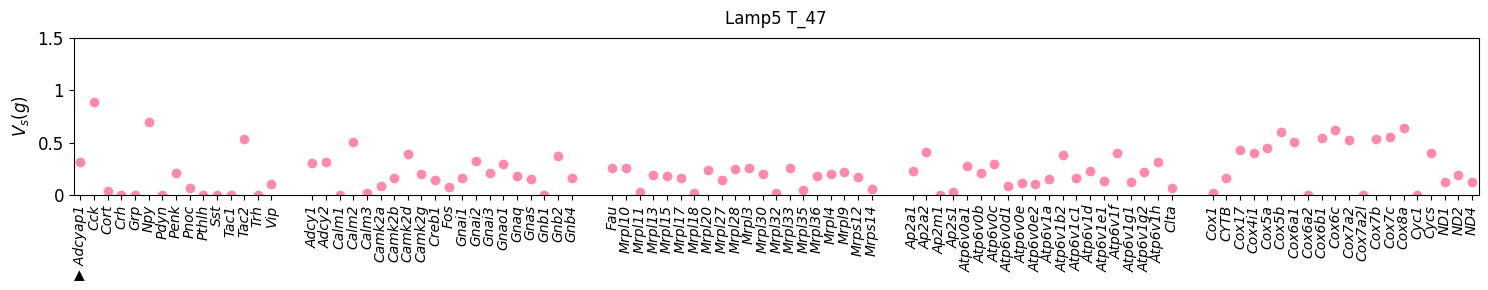

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


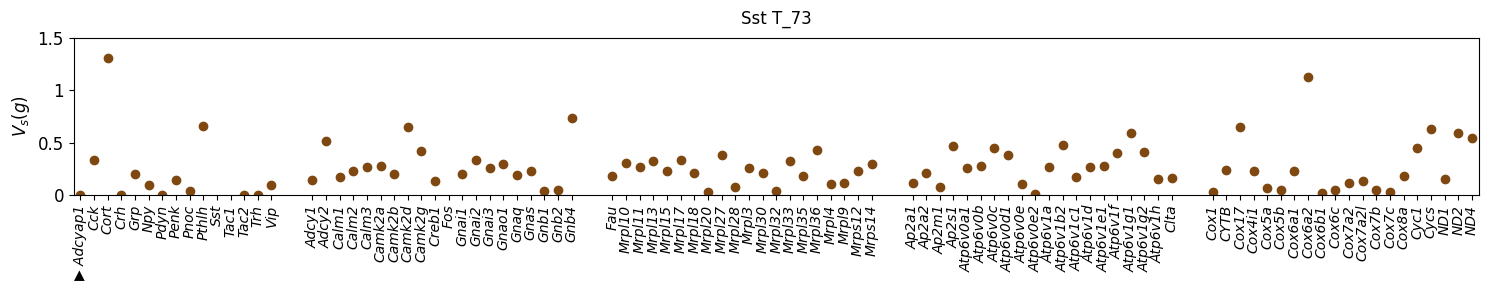

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


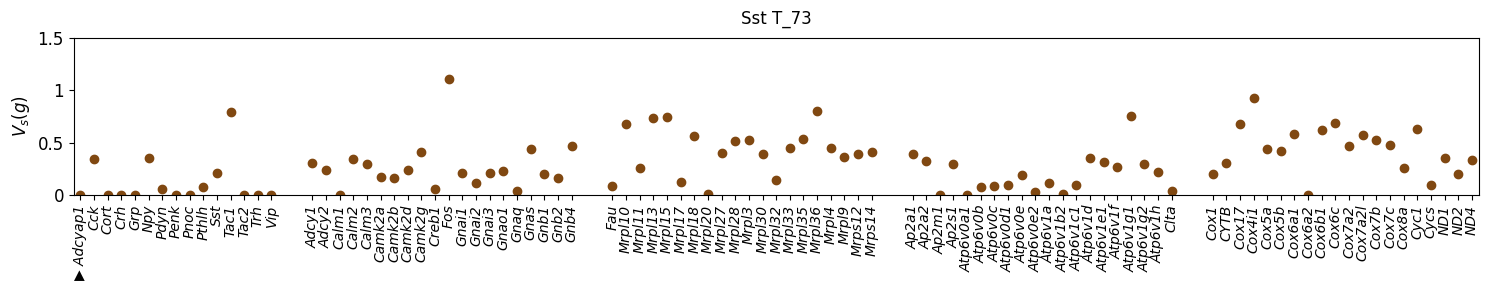

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


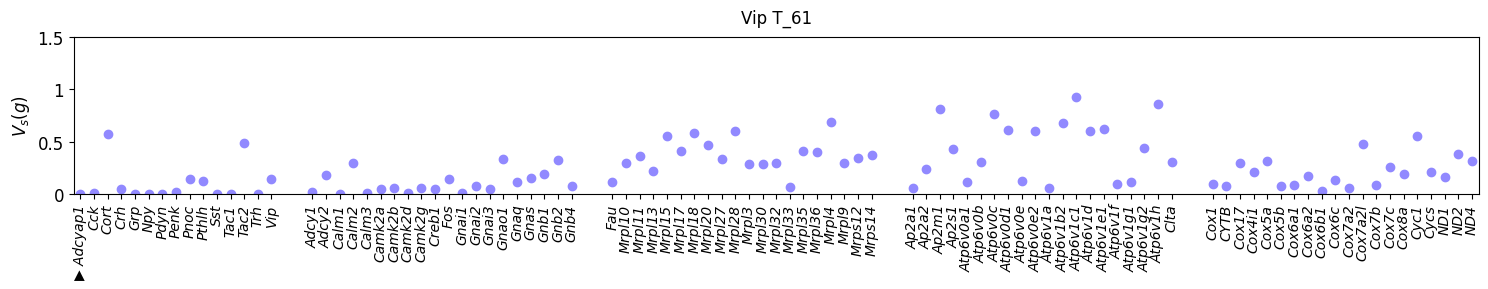

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


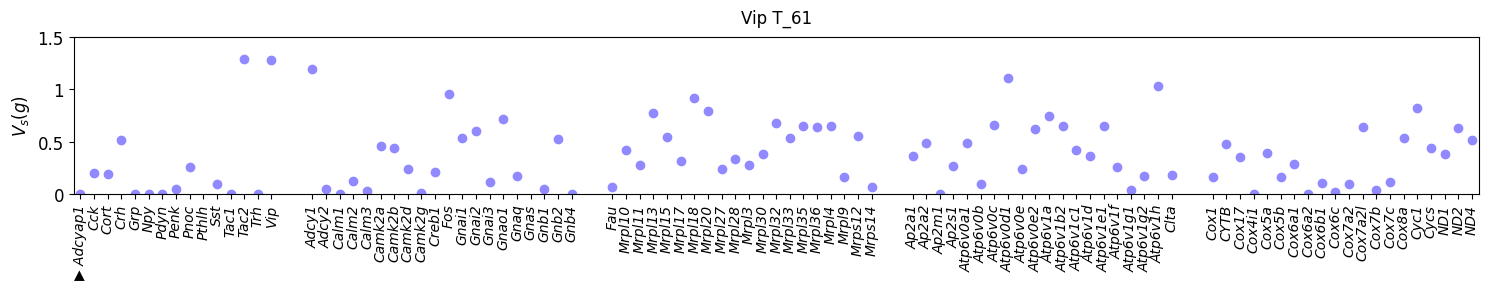

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


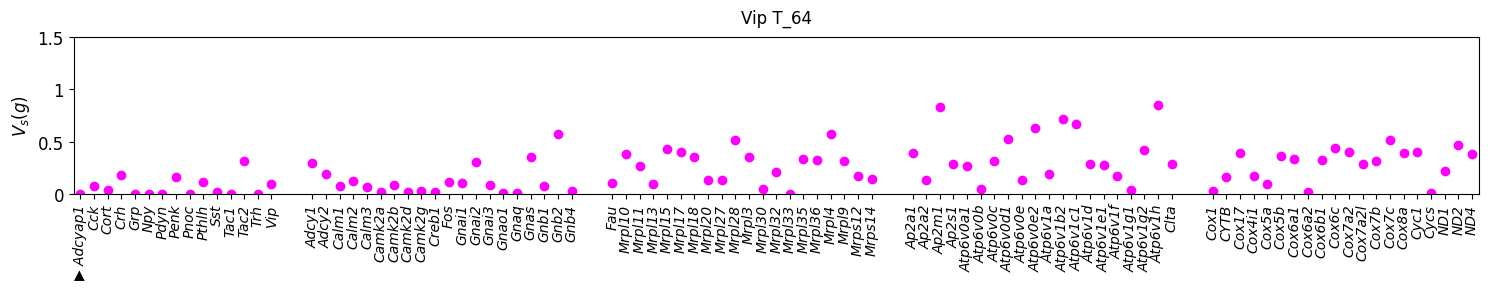

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


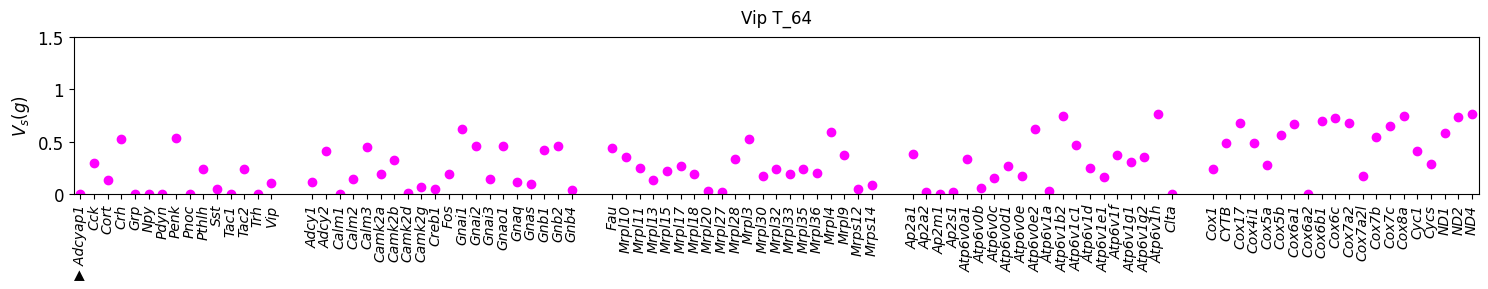

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


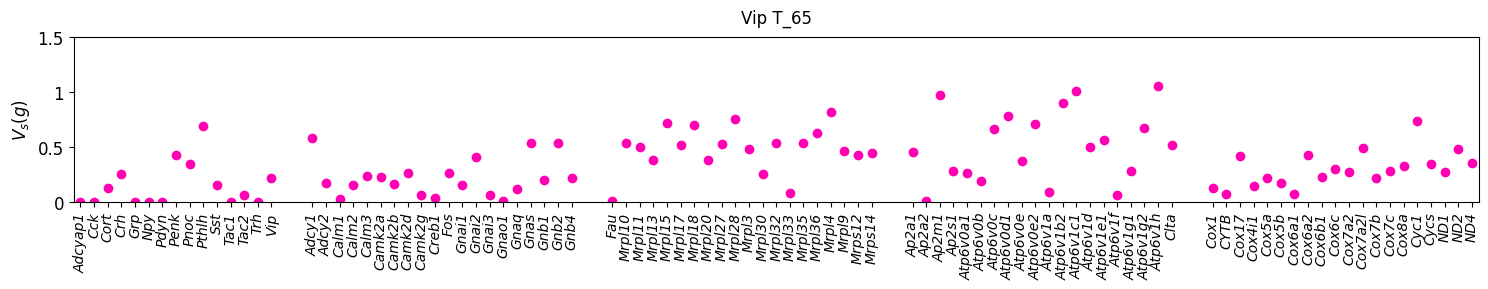

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


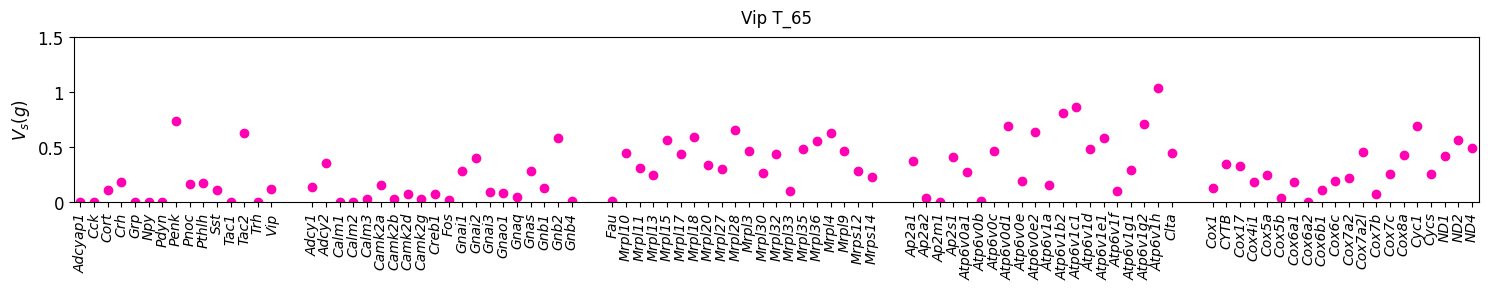

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


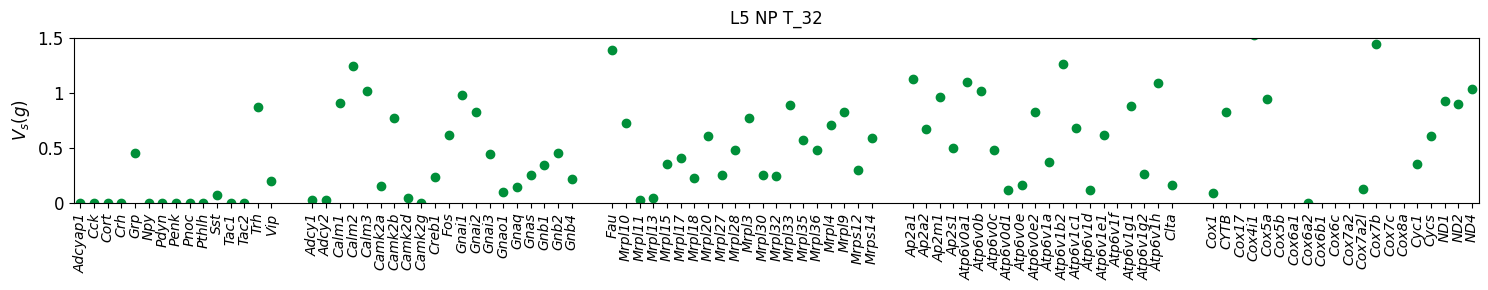

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


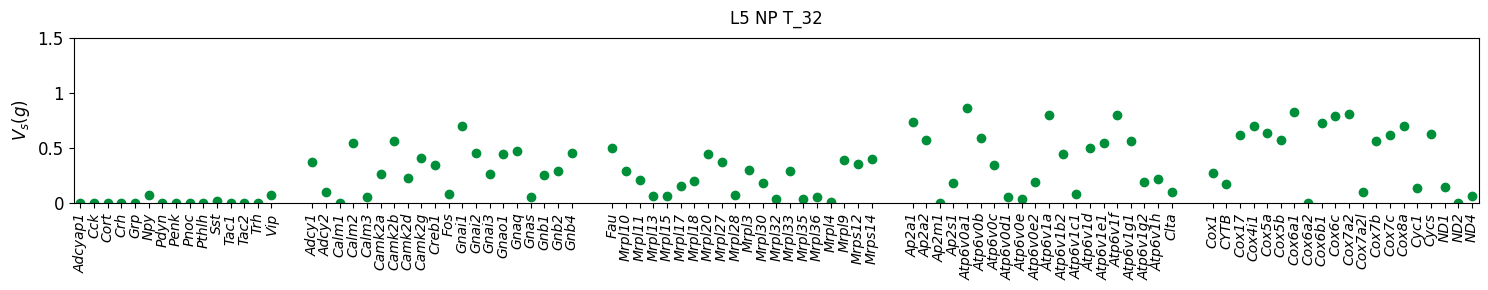

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


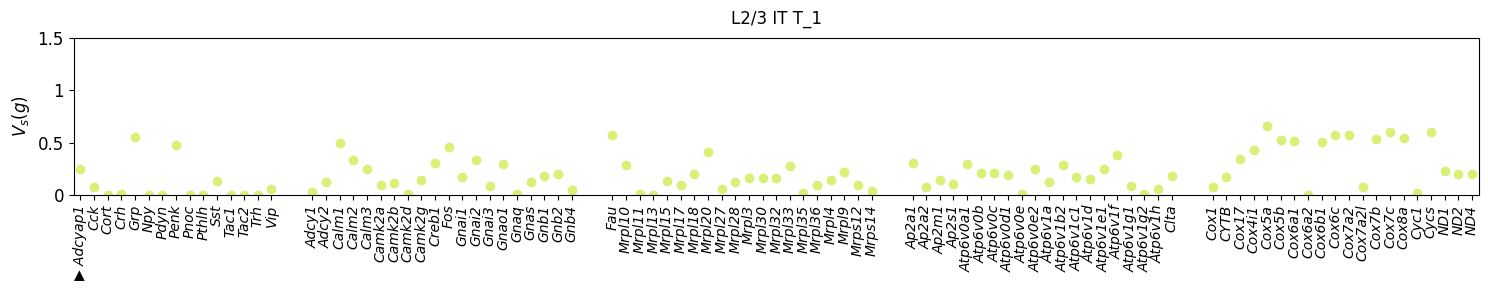

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


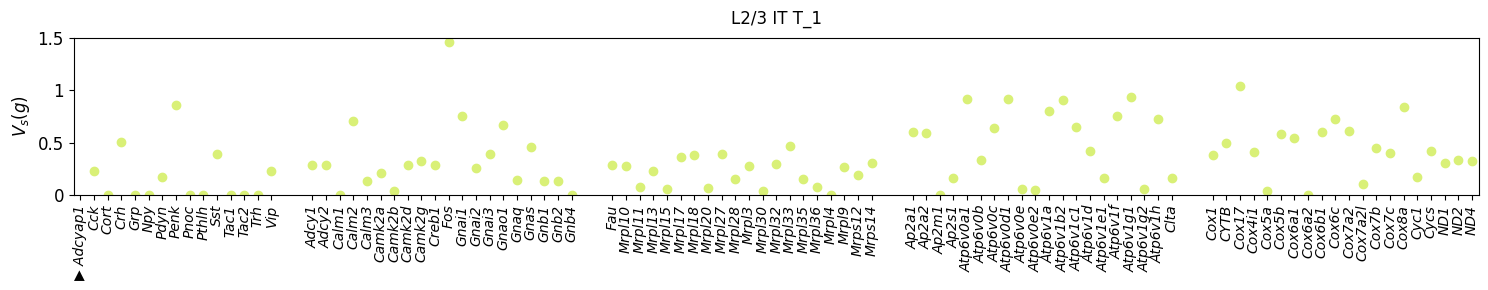

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


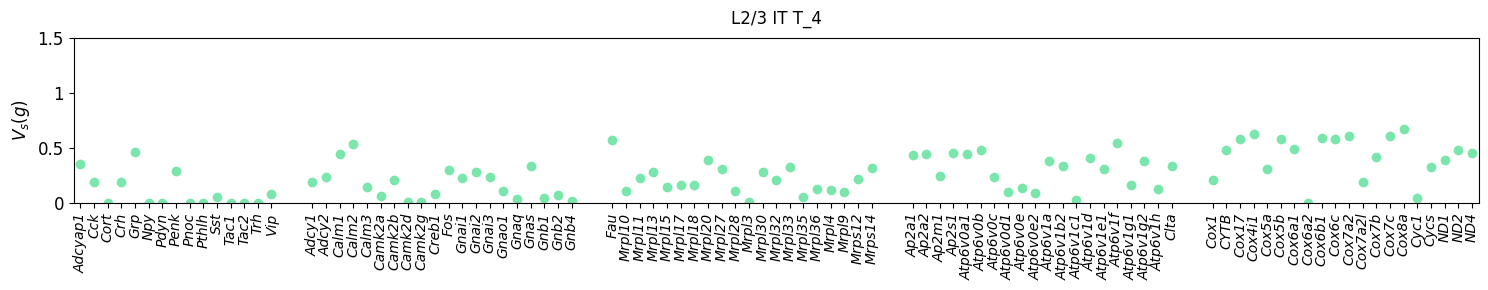

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


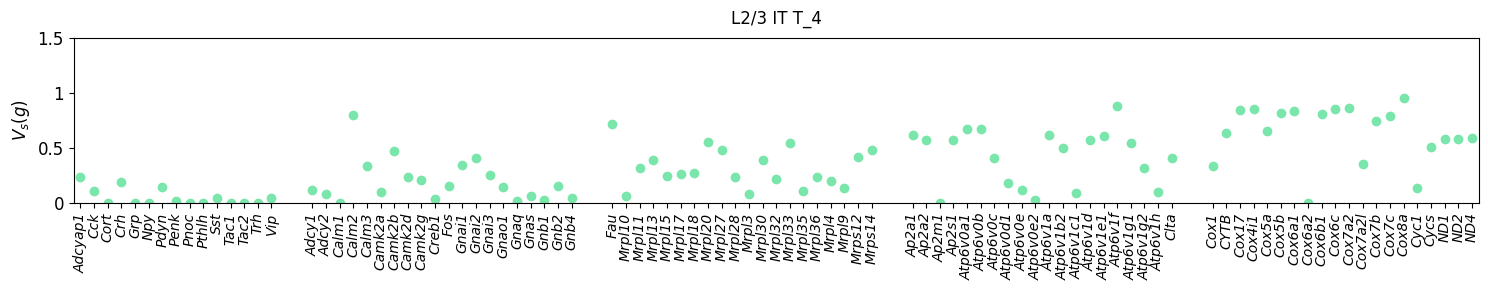

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


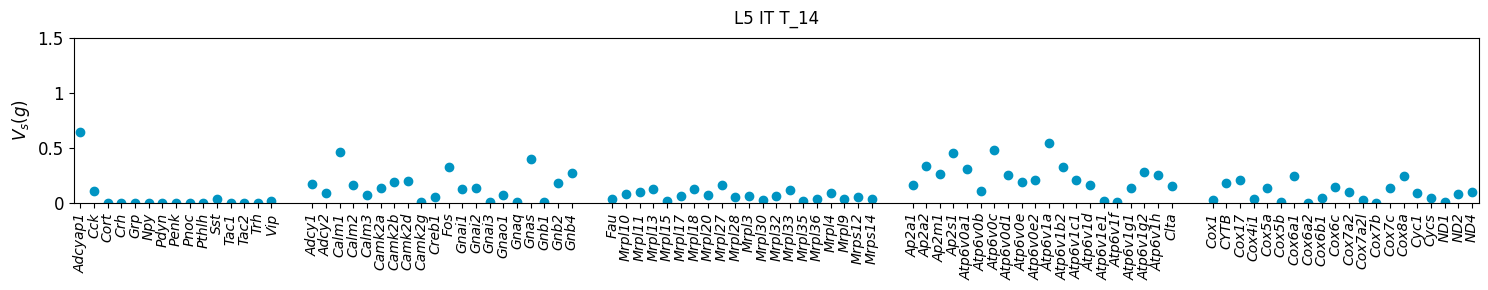

NPP
Circadian entrainment 
Ribosome 
Synaptic vesicle cycle 
Oxidative phosphorylation 


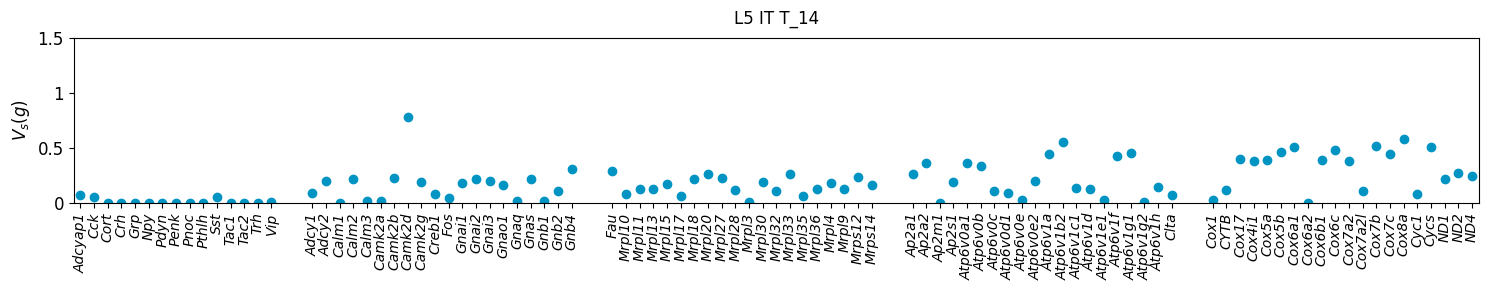

In [10]:
gg_s = []
path_idx = [0, 3, 8, 19, 6]
gg_s.append(g_subset[0])
gg_s.append(g_subset[3][:20])
gg_s.append(g_subset[8][:20])
gg_s.append(g_subset[19][:20])
gg_s.append(g_subset[6][16:16+20])
shift = 3

for i_cat, cc in enumerate(selected_c): 
    c_idx = np.where(c_cat==cc)[0][0]

    for arm in range(n_arm):
        g_travers = g_var_mean[c_idx, arm, 0, :]
        fig, ax = plt.subplots(figsize=[15, 3])
        xticks = []
        xtick_label = []
        for ig, g_s in enumerate(gg_s):
            print(signaling_pathways[path_idx[ig]])
            if ig > 0:
                x_s = np.arange(len(g_s)) + shift + x_s[-1]
            else:
                x_s = np.arange(len(g_s))

            ax.errorbar(x_s, g_travers[g_s], yerr=0, linestyle='None', fmt='o', 
                        markersize=6, capsize=1, color=color[i_cat])
            xticks.append(x_s)
            g_label = data['gene_id'][g_s]
            if 'COX1' in g_label:
                cox_idx = np.where(g_label == 'COX1')[0][0]
                g_label[cox_idx] = 'Cox1'
            indx = np.where(c_label == cc)[0]
            sum_exp_c = np.sum(gene_exp[indx, :], axis=0)
            zg_indx = np.where(sum_exp_c[0, g_s] == 0)[0]
            new_g = ['▶ ' + sg for sg in g_label[zg_indx]]
            g_label[zg_indx] = new_g
            xtick_label.append(g_label)

        xticks = np.concatenate(xticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.concatenate(xtick_label), rotation=90, fontsize=10, style='italic')
        ax.set_xlabel('')
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
            tick.set_fontsize(12)

        ax.set_ylabel(r'$V_{s}(g)$', fontsize=12)
        ax.set_xlim([xticks[0] - .5, xticks[-1] + .5])
        ax.set_ylim([0, 1.5])
        ax.set_yticks([0, 0.5, 1, 1.5], [0, 0.5, 1, 1.5])
        ax.set_title(c_ano[i_cat], fontsize=12, pad=10)
        plt.tight_layout()
        plt.savefig(saving_folder + f'/State/supp_traversal_{cc}_pc_1_arm_{arm}_2.png', dpi=600)
        plt.show()

In [11]:
file = open(saving_folder + f'/State/state_mu_pca_K_{model_order}.pickle', 'rb')
s_dict = pickle.load(file)
s_mu = s_dict['s_mu']
s_travers = s_dict['s_travers']
c_cat = s_dict['c_cat']

eval_model = glob.glob(saving_folder + '/model/model_eval*')
eval_data = pickle.load(open(eval_model[-1], "rb"))
# eval_data['data_indx'] = np.concatenate(eval_data['data_indx'])
eval_data['data_indx'] = eval_data['data_indx'].astype(int) 

arm = 0
categories = eval_data['predicted_label'][arm]

m_size = 3
alp = .8
fontsize = 18
    
for ic, c in enumerate(c_cat):
    idx_c = np.where(categories == c)[0]
    fig = plt.figure(figsize=(5, 5))
    sns.set_theme()
    sns.set(rc={'axes.facecolor':'#ffffff'})

    axs = fig.add_subplot(1,1,1)
    axs.scatter(eval_data['state_mu'][arm][:, 0], eval_data['state_mu'][arm][:, 1], color='#dbdbde', s=2, alpha=alp)
    axs.scatter(eval_data['state_mu'][arm][idx_c, 0], eval_data['state_mu'][arm][idx_c, 1], color=T_color[ic], s=6, alpha=1)
    axs.scatter(s_travers[ic][arm, :, 0], s_travers[ic][arm, :, 1], color='black', s=0.05, alpha=1)
    axs.set_xlabel(r'$s_{T_1}$', fontsize=fontsize)
    axs.set_ylabel(r'$s_{T_2}$', fontsize=fontsize)
    axs.xaxis.set_tick_params(labelsize=10)
    axs.yaxis.set_tick_params(labelsize=10)
    axs.set_ylim([-2.1, 3])
    axs.set_xlim([-2.5, 2.5])
    axs.set_title(T_annotation[ic], fontsize=18, pad=10)
    axs.grid(False)
    axs.spines['top'].set_color('#2d2d2d')
    axs.spines['right'].set_color('#2d2d2d')
    axs.spines['left'].set_color('#2d2d2d')
    axs.spines['bottom'].set_color('#2d2d2d')
    fig.tight_layout()
    plt.savefig(saving_folder + f'/State/s_mu/state_mu_arm_{arm}_c_{c}.png', dpi=600)
    plt.show()

IndexError: list index out of range

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


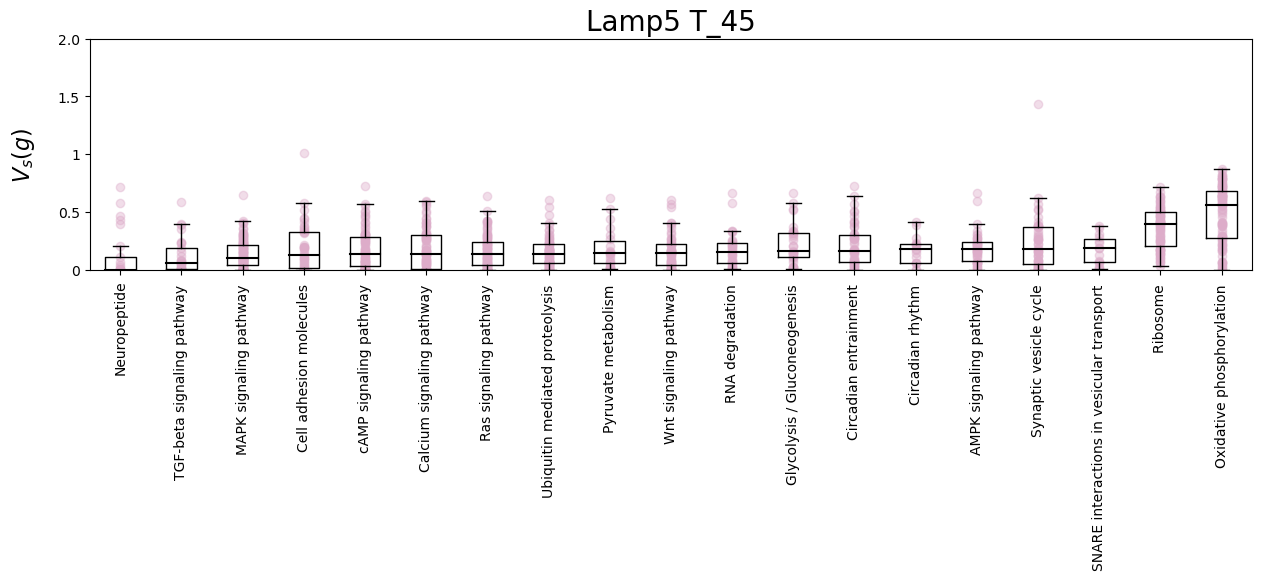

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


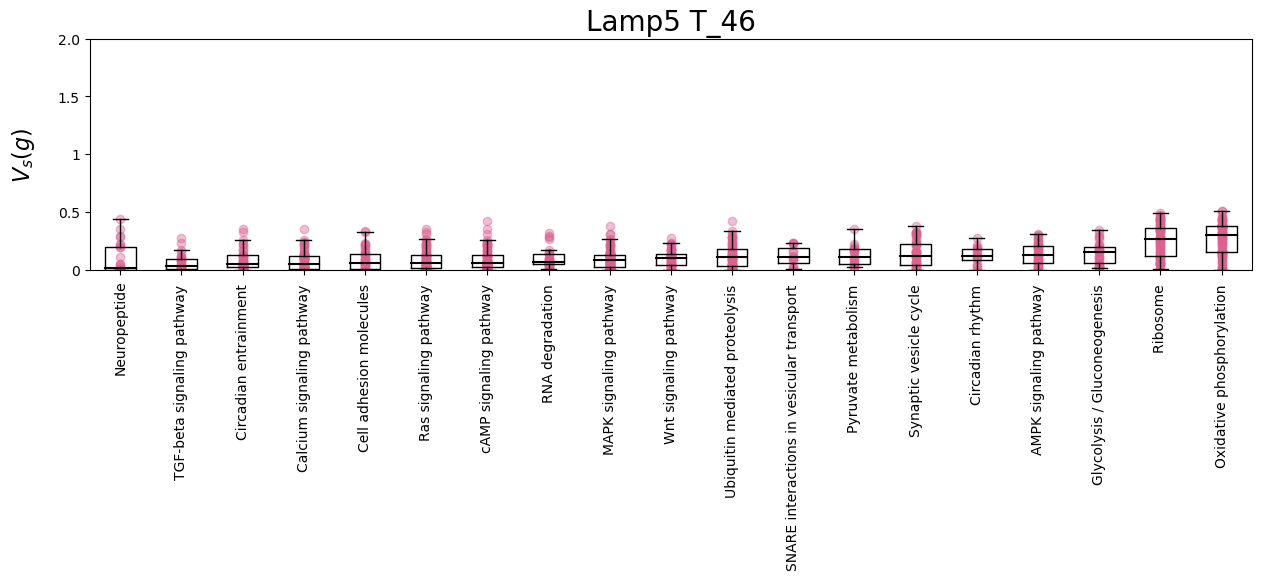

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


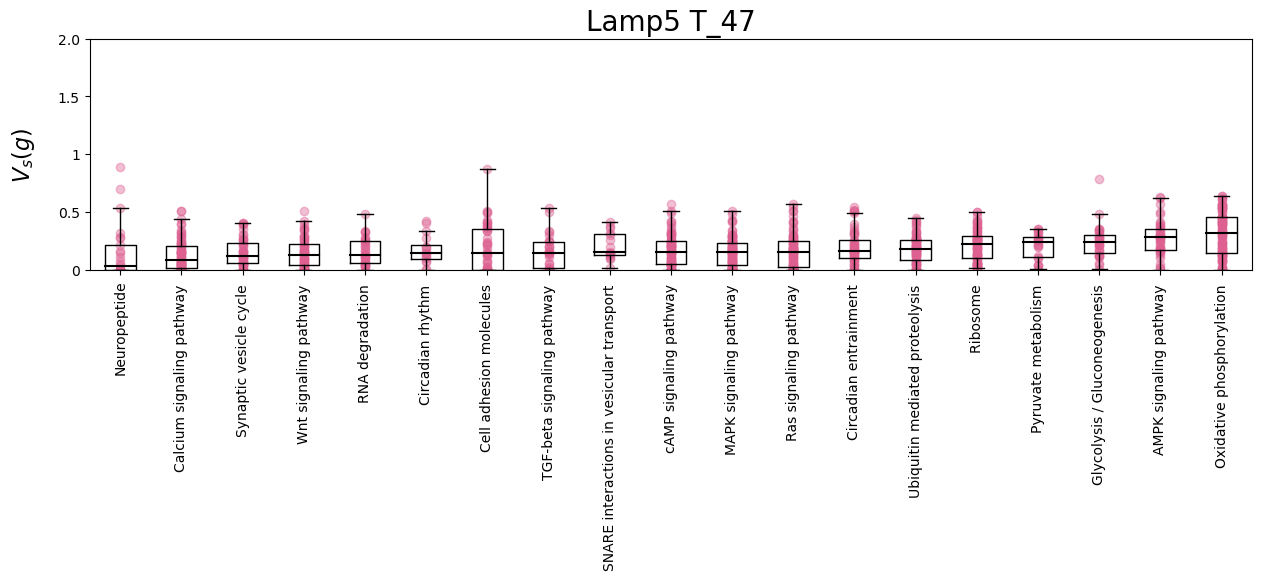

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


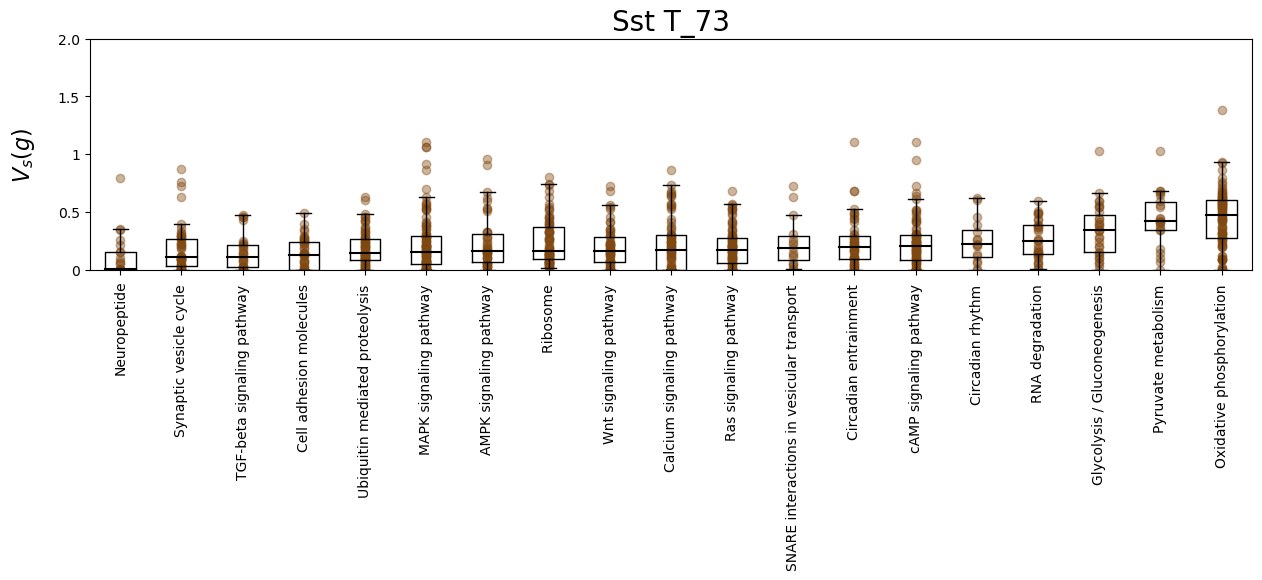

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


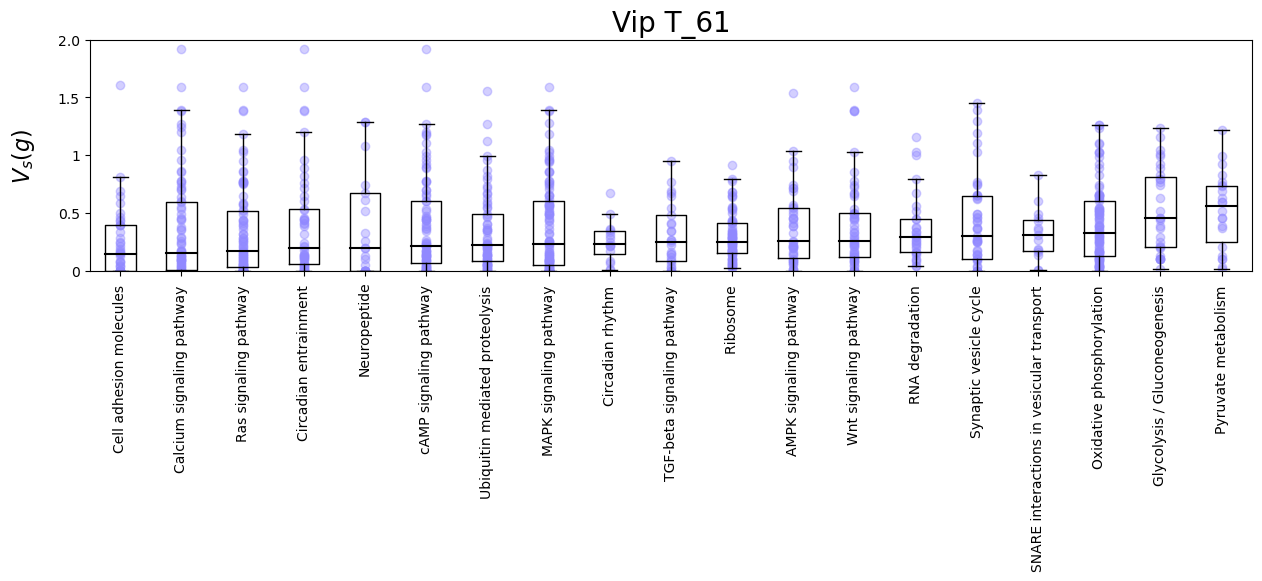

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


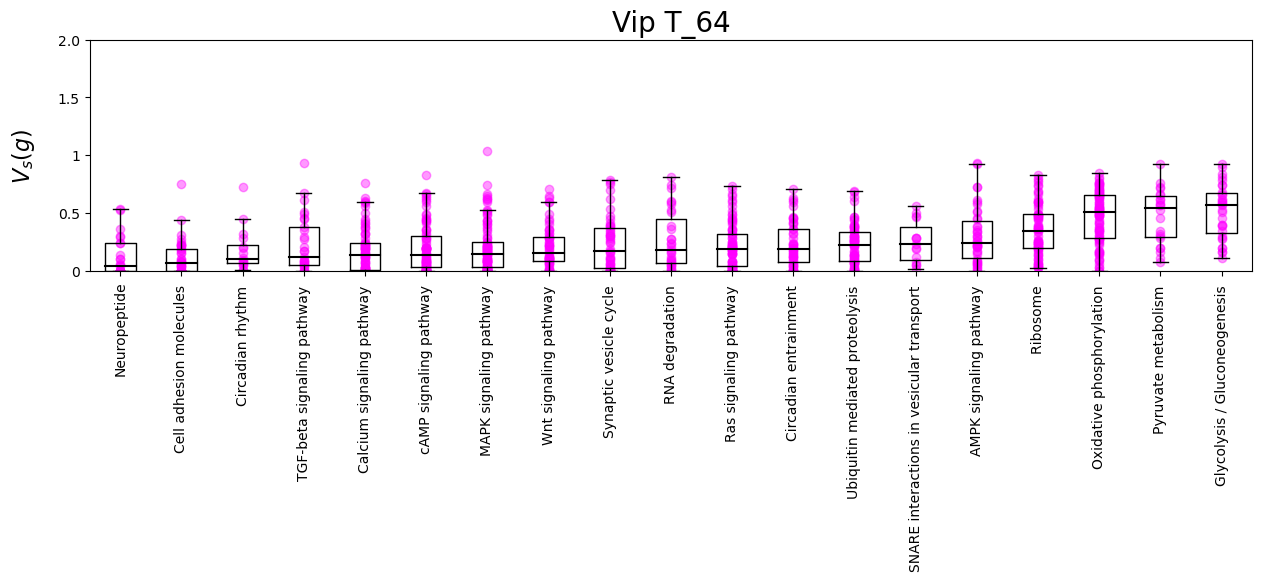

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


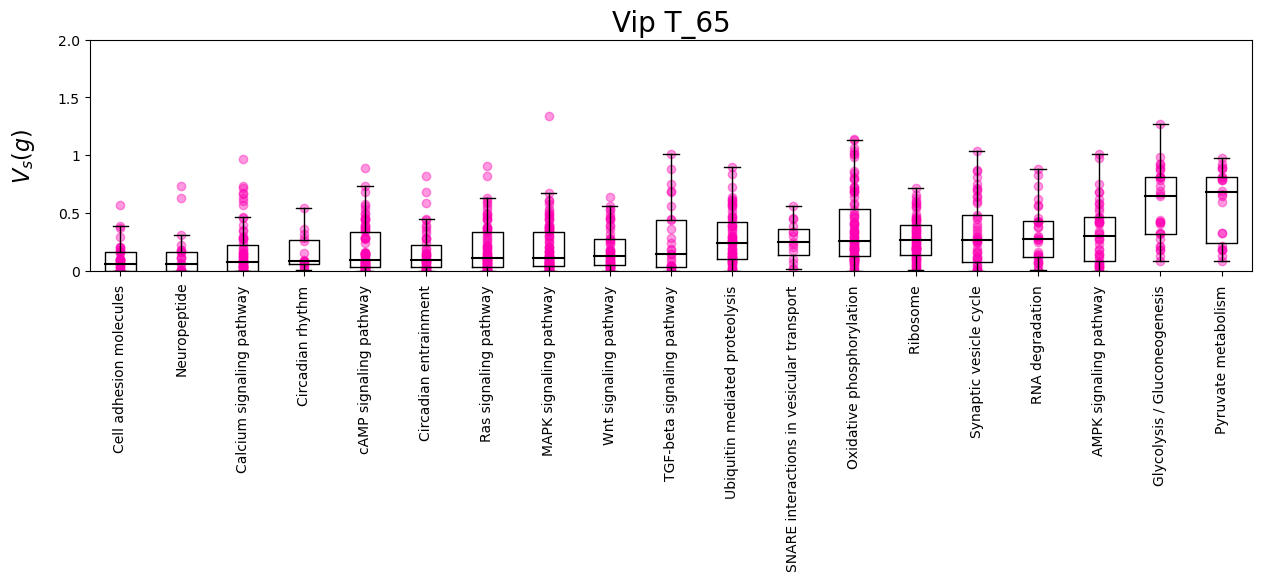

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


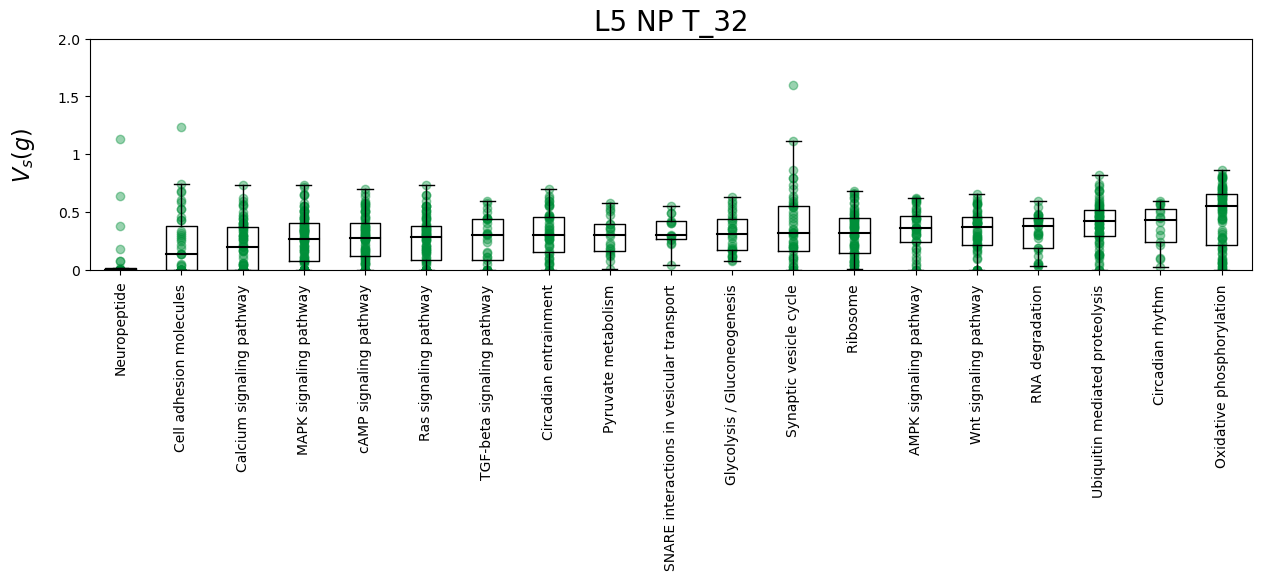

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


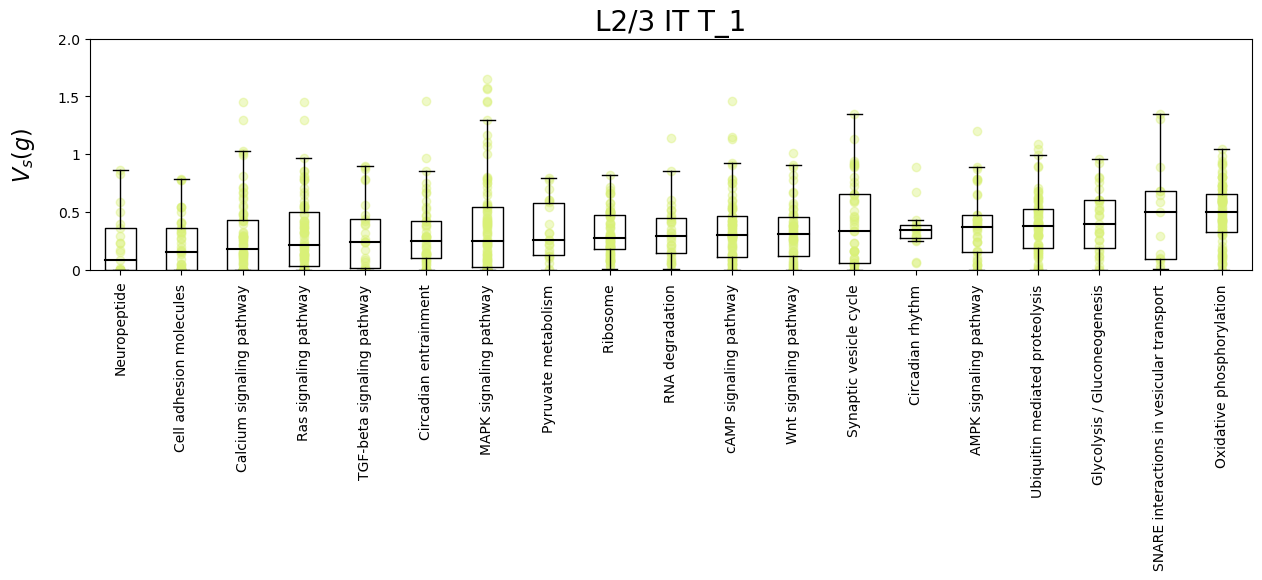

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


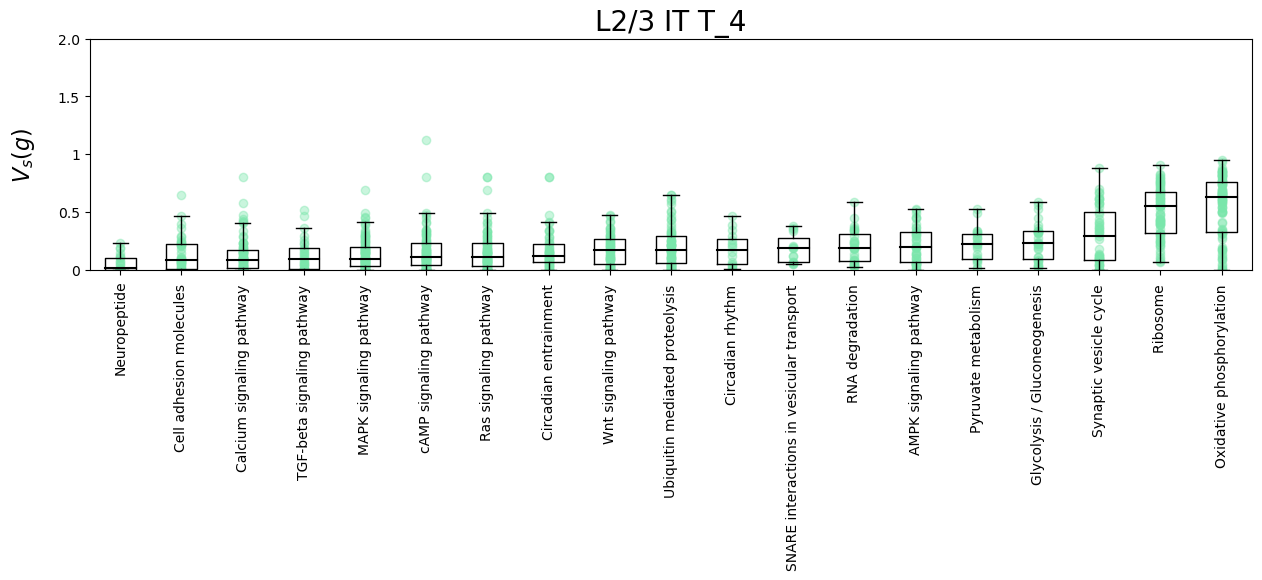

/Users/yeganeh.marghi/miniconda3/envs/tf14-cpu/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


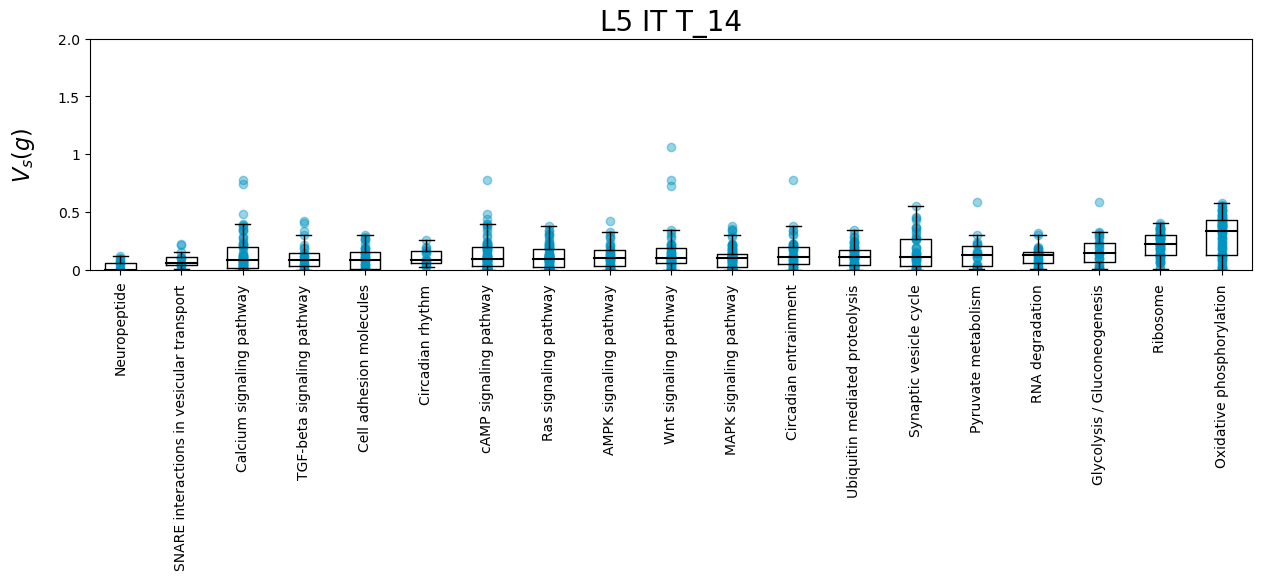

In [ ]:
boxprops = dict(color="black", linewidth=1)
medianprops = dict(color="black", linewidth=1.5)

for i_c, cc in enumerate(selected_c):
    vals, names, xs = [], [], []
    path_med = []
    c_idx = np.where(c_cat==cc)[0][0]
    plt.figure(figsize=[15, 3])
    for i_g, g_s in enumerate(g_subset):
        if i_g == 0:
            g_s = np.concatenate((g_subset[0], g_subset[1]))
            sig_path = 'Neuropeptide'
            ii_g = i_g
        elif i_g in [1, 7, 18]:
            continue
        else:
            ii_g = i_g - 1
            sig_path = signaling_pathways[i_g]
            g_s = np.array(g_s)
        g_travers = g_var_mean[c_idx, 1, 0, g_s]
        path_med.append(np.median(g_travers))
        vals.append(g_travers)
        names.append(sig_path)
        xs.append(np.random.normal(ii_g + 1, 0.04, g_travers.shape[0]))  
    
    path_med = np.array(path_med)
    sort_idx = np.argsort(path_med)
    vals = [vals[ii] for ii in sort_idx]
    names = [names[ii] for ii in sort_idx]
#     xs_ = [xs[ii] for ii in sort_idx]
    
    plt.boxplot(vals, labels=names, showfliers=False, boxprops=boxprops, medianprops=medianprops)
    for iv, val in enumerate(vals):
        plt.scatter(iv+1*np.ones(len(val)), val, alpha=0.4, color=color[i_c])

    plt.title(c_ano[i_c], fontsize=20)
    plt.ylabel(r'$V_{s}(g)$', fontsize=16, labelpad=15)
    plt.xticks(rotation=90)
    plt.yticks([0, 0.5, 1, 1.5, 2.], [0, 0.5, 1, 1.5, 2.])
    plt.tight_layout()
    plt.ylim([0, 2])
    plt.savefig(saving_folder + f'/State/signaling_pathways/s_pc_paths_K_{model_order}_c_{i_c}.png',
                bbox_inches='tight', dpi=600)
    plt.show()